# Preface

This notebook is focused on

* exhaustive EDA of COVID-19 pandemic metrics
* exhaustive EDA of Google Mobility Trends dataset/metrics (in the evidence of COVID-19 pandemic, collected and updated regularly since Feb 15, 2020)
* correlation of COVID-19 pandemic metrics (confirmed, deaths, recovered and the derivative trend and lag metrics) with the mobility trend metrics

**Note:** In the scope of the current data analytics effort, we are going to analize Google Mobility Trends on the national level, without breaking the analysis down by country regions/provinces.

In [1]:
!pip install pdpipe

     |████████████████████████████████| 48 kB 1.5 MB/s eta 0:00:011
  Created wheel for decore: filename=decore-0.0.1-py2.py3-none-any.whl size=4190 sha256=79e6b6c7240ef3eeb29863d859eee6667e8b978ba43b4d423932928d3ee78cf4
  Stored in directory: /root/.cache/pip/wheels/71/8f/e1/b37357faaa92c7fbd2a8f735f96fcf032df04bcd3875465a3f
Successfully built decore


In [2]:
import pandas as pd
import pdpipe as pdp
import numpy as np

import pycountry

# the commented code below will only be useful in a stand-alone version
#from google.oauth2 import service_account
#import google.auth

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from sklearn import preprocessing
import time
from datetime import datetime

In [3]:
# auxiliary helper functions and common pipelines reused below

def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

def histograms_numeric_columns(df, numerical_columns, col_wrap):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=col_wrap, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g


# map country alpha 2 codes to country names to display in the map
def get_country_name(alpha_2_code):
    '''
    Takes the alpha-2 country code as an input
    Returns a full country name
    '''
    country_obj = pycountry.countries.get(alpha_2=alpha_2_code)
    country_name = country_obj.name
    return country_name


# map country alpha 3 codes to country names to display in the map
def get_country_name_by_alpha3(alpha_3_code):
    '''
    Takes the alpha-3 country code as an input
    Returns a full country name
    '''
    country_name = ""
    country_obj = pycountry.countries.get(alpha_3=alpha_3_code)
    if country_obj is None:
        country_name = alpha_3_code
    else:
        country_name = country_obj.name
    return country_name


country_name_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['country_id'], get_country_name),
])

country_name_pipeline3 = pdp.PdPipeline([
    pdp.ApplyByCols(['country_id'], get_country_name_by_alpha3),
])

# set the size of the geo bubble
def set_size(value):
    '''
    Takes the numeric value of a parameter to visualize on a map (Plotly Geo-Scatter plot)
    Returns a number to indicate the size of a bubble for a country which numeric attribute value 
    was supplied as an input
    '''
    result = np.log(1+value/1000)
    if result < 0:
        result = 0.001
    return result

# Getting and Pre-processing COVID-19 Pandemic Data¶
I will load public open data about Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE (https://systems.jhu.edu/research/public-health/ncov/), as per their online repository at https://github.com/CSSEGISandData/COVID-19 (updated daily)

In [4]:
confirmed_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered_ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

Next I will melt and transform the canonic time series data into a long-form dataframes

In [5]:
confirmed_ts_melted_df = confirmed_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='confirmed').copy()

deaths_ts_melted_df = deaths_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='deaths').copy()

recovered_ts_melted_df = recovered_ts_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long',],
                     var_name='covid_date', value_name='recovered').copy()

Now we will further transform the data as well as put them into the single dataframe

In [6]:
pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['covid_date'], pd.to_datetime),
    pdp.ColRename({'Country/Region': 'country_id', 'Province/State': 'state', 'Lat': 'lat', 'Long': 'long'})
])

confirmed_ts_fcg_df = pipeline.apply(confirmed_ts_melted_df).sort_values(by=['country_id', 'covid_date'])
deaths_ts_fcg_df = pipeline.apply(deaths_ts_melted_df).sort_values(by=['country_id', 'covid_date'])
recovered_ts_fcg_df = pipeline.apply(recovered_ts_melted_df).sort_values(by=['country_id', 'covid_date'])

covid_df = pd.merge(
    pd.merge(confirmed_ts_fcg_df, deaths_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date']),
    recovered_ts_fcg_df, on=['state', 'country_id', 'lat', 'long','covid_date'])

covid_df.head()

state   country_id   lat  long covid_date  confirmed  deaths  recovered
0   NaN  Afghanistan  33.0  65.0 2020-01-22          0       0          0
1   NaN  Afghanistan  33.0  65.0 2020-01-23          0       0          0
2   NaN  Afghanistan  33.0  65.0 2020-01-24          0       0          0
3   NaN  Afghanistan  33.0  65.0 2020-01-25          0       0          0
4   NaN  Afghanistan  33.0  65.0 2020-01-26          0       0          0

The date range covered by the current COVID-19 dataset is as follows

In [7]:
covid_start_date = covid_df["covid_date"].dt.date.min()
covid_end_date = covid_df["covid_date"].dt.date.max()
print("Start Date:", covid_start_date)
print("End Date:", covid_end_date)

Start Date: 2020-01-22
End Date: 2020-06-22


# Getting World Population Charts
In order to build certain useful COVID-19 pandemic features (like infection rate, mortality rate from COVID-19), we will have to obtain the country population data.

In this case, we are going to use World Bank's world population data as of the end of 2018 as uploaded to BigQuery Public Datasets area (bigquery-public-data:world_bank_global_population dataset)

In [8]:
# World population SQL query
sql = """
SELECT 
country_code as country_id, -- alpha3 country code
year_2018 as pop
FROM `bigquery-public-data.world_bank_global_population.population_by_country` 
WHERE year_2018 IS NOT NULL
"""

# we are going to get use of Using Kaggle's public dataset BigQuery integration to aid researcher needs free of charge 
# you can refer to https://www.kaggle.com/bigquery/covid19-google-mobility to see the terms and conditions of such an integration
# explained

from google.cloud import bigquery
client = bigquery.Client()

# Set up the query
query_job = client.query(sql)

# Make an API request  to run the query and return a pandas DataFrame
population_df = query_job.to_dataframe()

# Note: the code commented below is used in a stand-alone notebook where google auth and standard pandas capabilities are
# better to utilize
# population_df = pd.read_gbq(sql, project_id=your_project_id, credentials=credentials, dialect='standard')

display(population_df.head(20))

Using Kaggle's public dataset BigQuery integration.


country_id         pop
0         SXM       40654
1         PSE     4569087
2         SRB     6982084
3         KHM    16249798
4         ARE     9630959
5         CYP     1189265
6         LMC  3022905169
7         MDV      515696
8         LIC   705417321
9         PER    31989256
10        EAR  3249140605
11        FJI      883483
12        TCD    15477751
13        MNA   382896715
14        TMN   378327628
15        WLD  7594270356
16        SAU    33699947
17        DOM    10627165
18        KEN    51393010
19        VEN    28870195

After we get the World Bank's population data from BigQuery, we replace the alpha 3 country codes with the canonical country names, to make it ready for the merge with COVID-19 pandemics dataset

In [9]:
# replace country alpha3 code with country name
population_df = country_name_pipeline3.apply(population_df)

In [10]:
# merge COVID-19 and population datrasets

covid_df = pd.merge(covid_df,
                 population_df,
                 on='country_id')

# COVID-19 Pandemic Feature Enrichment

To the major extent, the feature engineering flow below is inspired by the ideas in https://www.kaggle.com/twhelan/code-to-create-an-enriched-dataset

On top of the abvoe-mentioned feature engineering inspirations, I added Exponential Moving Average features.

## Basic clean-up, dates, lag, and trend features

In [11]:
# Basic clean-up and dates features

le = preprocessing.LabelEncoder()

covid_df_corr = covid_df.copy()
covid_df_corr['day_num'] = le.fit_transform(covid_df_corr.covid_date)
covid_df_corr['day'] = covid_df_corr['covid_date'].dt.day
covid_df_corr['month'] = covid_df_corr['covid_date'].dt.month
covid_df_corr['year'] = covid_df_corr['covid_date'].dt.year

# Fill null values given that we merged train-test datasets
covid_df_corr['state'].fillna("None", inplace=True)
covid_df_corr['confirmed'].fillna(0, inplace=True)
covid_df_corr['deaths'].fillna(0, inplace=True)
covid_df_corr['recovered'].fillna(0, inplace=True)

# lag and trend calculation
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)

        # df[col1] = df[column] + df[column2]
    return df
  
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = "Lag_" + column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df


ts = time.time()
covid_df_corr = calculate_lag(covid_df_corr, range(1,7), 'confirmed')
covid_df_corr = calculate_lag(covid_df_corr, range(1,7), 'deaths')
covid_df_corr = calculate_lag(covid_df_corr, range(1,7), 'recovered')
covid_df_corr = calculate_trend(covid_df_corr, range(1,7), 'confirmed')
covid_df_corr = calculate_trend(covid_df_corr, range(1,7), 'deaths')
covid_df_corr = calculate_trend(covid_df_corr, range(1,7), 'recovered')

covid_df_corr.replace([np.inf, -np.inf], 0, inplace=True)
covid_df_corr.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.1599407196044922


## Adding Exponential Moving Averages

In [12]:
# Ref.: https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
covid_df_corr['confirmed_ema'] = covid_df_corr['confirmed'].ewm(span=7,adjust=False).mean()
covid_df_corr['deaths_ema'] = covid_df_corr['deaths'].ewm(span=7,adjust=False).mean()
covid_df_corr['recovered_ema'] = covid_df_corr['recovered'].ewm(span=7,adjust=False).mean()

In [13]:
display(covid_df_corr.head(10))

state   country_id   lat  long covid_date  confirmed  deaths  recovered  \
0  None  Afghanistan  33.0  65.0 2020-01-22          0       0          0   
1  None  Afghanistan  33.0  65.0 2020-01-23          0       0          0   
2  None  Afghanistan  33.0  65.0 2020-01-24          0       0          0   
3  None  Afghanistan  33.0  65.0 2020-01-25          0       0          0   
4  None  Afghanistan  33.0  65.0 2020-01-26          0       0          0   
5  None  Afghanistan  33.0  65.0 2020-01-27          0       0          0   
6  None  Afghanistan  33.0  65.0 2020-01-28          0       0          0   
7  None  Afghanistan  33.0  65.0 2020-01-29          0       0          0   
8  None  Afghanistan  33.0  65.0 2020-01-30          0       0          0   
9  None  Afghanistan  33.0  65.0 2020-01-31          0       0          0   

        pop  day_num  ...  Trend_deaths_6  Trend_recovered_1  \
0  37172386        0  ...             0.0                0.0   
1  37172386        1  ...             0.0                0.0   
2  37172386        2  ...             0.0                0.0   
3  37172386        3  ...             0.0                0.0   
4  37172386        4  ...             0.0                0.0   
5  37172386        5  ...             0.0                0.0   
6  37172386        6  ...             0.0                0.0   
7  37172386        7  ...             0.0                0.0   
8  37172386        8  ...             0.0                0.0   
9  37172386        9  ...             0.0                0.0   

   Trend_recovered_2  Trend_recovered_3  Trend_recovered_4  Trend_recovered_5  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   
5                0.0                0.0                0.0                0.0   
6                0.0                0.0                0.0                0.0   
7                0.0                0.0                0.0                0.0   
8                0.0                0.0                0.0                0.0   
9                0.0                0.0                0.0                0.0   

   Trend_recovered_6  confirmed_ema  deaths_ema  recovered_ema  
0                0.0            0.0         0.0            0.0  
1                0.0            0.0         0.0            0.0  
2                0.0            0.0         0.0            0.0  
3                0.0            0.0         0.0            0.0  
4                0.0            0.0         0.0            0.0  
5                0.0            0.0         0.0            0.0  
6                0.0            0.0         0.0            0.0  
7                0.0            0.0         0.0            0.0  
8                0.0            0.0         0.0            0.0  
9                0.0            0.0         0.0            0.0  

[10 rows x 52 columns]

## Adding Additional Pandemic Features and Country Population

In [14]:
def add_extra_trends(df):

    df1 = df.copy()

    df1['NewConfirmed'] = df1['confirmed'] - df1['confirmed'].shift(1)
    df1['NewConfirmed'] = df1['NewConfirmed'].fillna(df1['confirmed'])
    df1['PreviousDayNewConfirmed'] = df1['NewConfirmed']
    df1['PreviousDayNewConfirmed'] = df1['PreviousDayNewConfirmed'].fillna(0)
    df1['growth_factor'] = df1['confirmed'] / df1['PreviousDayNewConfirmed'] # https://www.youtube.com/watch?v=Kas0tIxDvrg
    df1['growth_factor'] = df1['growth_factor'].rolling(3).median() # add smoothing
        

    df1['NewFatalities'] = df1['deaths'] - df1['deaths'].shift(1)
    df1['NewFatalities'] = df1['NewFatalities'].fillna(df1['deaths'])
    df1['PreviousDayNewFatalities'] = df1['deaths'].shift(1) - df1['deaths'].shift(2)
    df1['PreviousDayNewFatalities'] = df1['PreviousDayNewFatalities'].fillna(0)
    df1['mortality_factor'] = df1['NewFatalities'] / df1['PreviousDayNewFatalities']
    df1['mortality_factor'] = df1['mortality_factor'].rolling(3).median() # add smoothing
        
    df1['case_fatality_rate'] = df1['deaths'] / df1['confirmed']
    df1['infection_rate'] = df1['confirmed'] / df1['pop']
    df1['mortality_rate'] = df1['deaths'] / df1['pop']
        
    df1 = df1.replace([np.inf, -np.inf], np.nan)
    df1['growth_factor'] = np.where(df1['confirmed']==0, 0, df1['growth_factor'].fillna(1.25)) # assumed
    df1['mortality_factor'] = np.where(df1['deaths']==0, 0, df1['mortality_factor'].fillna(1.25)) # assumed
    df1['case_fatality_rate'] = round(df1['case_fatality_rate'].fillna(0), 4)
    df1['infection_rate'] = round(df1['infection_rate'].fillna(0), 4)
    df1['mortality_rate'] = round(df1['mortality_rate'].fillna(0), 4)
      
    return df1.drop(['NewConfirmed', 'PreviousDayNewConfirmed', 'NewFatalities', 'PreviousDayNewFatalities'], axis=1)

covid_df_corr = add_extra_trends(covid_df_corr)
display(covid_df_corr.head(10))

state   country_id   lat  long covid_date  confirmed  deaths  recovered  \
0  None  Afghanistan  33.0  65.0 2020-01-22          0       0          0   
1  None  Afghanistan  33.0  65.0 2020-01-23          0       0          0   
2  None  Afghanistan  33.0  65.0 2020-01-24          0       0          0   
3  None  Afghanistan  33.0  65.0 2020-01-25          0       0          0   
4  None  Afghanistan  33.0  65.0 2020-01-26          0       0          0   
5  None  Afghanistan  33.0  65.0 2020-01-27          0       0          0   
6  None  Afghanistan  33.0  65.0 2020-01-28          0       0          0   
7  None  Afghanistan  33.0  65.0 2020-01-29          0       0          0   
8  None  Afghanistan  33.0  65.0 2020-01-30          0       0          0   
9  None  Afghanistan  33.0  65.0 2020-01-31          0       0          0   

        pop  day_num  ...  Trend_recovered_5  Trend_recovered_6  \
0  37172386        0  ...                0.0                0.0   
1  37172386        1  ...                0.0                0.0   
2  37172386        2  ...                0.0                0.0   
3  37172386        3  ...                0.0                0.0   
4  37172386        4  ...                0.0                0.0   
5  37172386        5  ...                0.0                0.0   
6  37172386        6  ...                0.0                0.0   
7  37172386        7  ...                0.0                0.0   
8  37172386        8  ...                0.0                0.0   
9  37172386        9  ...                0.0                0.0   

   confirmed_ema  deaths_ema  recovered_ema  growth_factor  mortality_factor  \
0            0.0         0.0            0.0            0.0               0.0   
1            0.0         0.0            0.0            0.0               0.0   
2            0.0         0.0            0.0            0.0               0.0   
3            0.0         0.0            0.0            0.0               0.0   
4            0.0         0.0            0.0            0.0               0.0   
5            0.0         0.0            0.0            0.0               0.0   
6            0.0         0.0            0.0            0.0               0.0   
7            0.0         0.0            0.0            0.0               0.0   
8            0.0         0.0            0.0            0.0               0.0   
9            0.0         0.0            0.0            0.0               0.0   

   case_fatality_rate  infection_rate  mortality_rate  
0                 0.0             0.0             0.0  
1                 0.0             0.0             0.0  
2                 0.0             0.0             0.0  
3                 0.0             0.0             0.0  
4                 0.0             0.0             0.0  
5                 0.0             0.0             0.0  
6                 0.0             0.0             0.0  
7                 0.0             0.0             0.0  
8                 0.0             0.0             0.0  
9                 0.0             0.0             0.0  

[10 rows x 57 columns]

# Correlation of the basic pandemic features

We are going to draw the correlation charts for basic pandemic features we just generated

## General Correlations

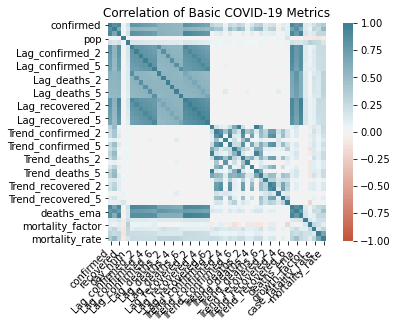

In [15]:
# Correlation of COVID-19 pandemic indicators
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({'state',	'country_id',	'lat',	'long',	'covid_date', 'year',
                  'day', 'month'
    })
])


data = corr_transform.apply(covid_df_corr)
corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of Basic COVID-19 Metrics')
ax

## More Detailed Outlook on Correlations with Confirmed

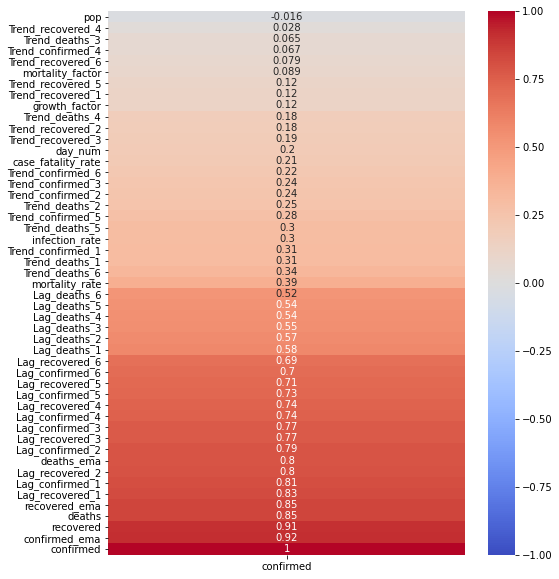

In [16]:
# check correlations with Confirmed
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({'state',	'lat',	'long', 'year',
                  'day', 'month'
    })
])
covid_df_corr = corr_transform.apply(covid_df_corr)
heatmap_numeric_w_dependent_variable(covid_df_corr, 'confirmed')

We find that there is a bunch of auto-correlations between *confirmed* cases and a number of derived lag features. Namely, the following feature variables show strong correlations with _confirmed_ cases

- deaths
- recovered
- confirmed_ema
- deaths_ema
- Lag_confirmed_1
- Lag_confirmed_2
- Lag_confirmed_3
- Lag_confirmed_4
- Lag_confirmed_5
- Lag_confirmed_6
- Lag_deaths_1
- Lag_deaths_2
- Lag_deaths_3
- Lag_deaths_4
- Lag_deaths_5

## More Detailed Outlook on Correlations with Deaths

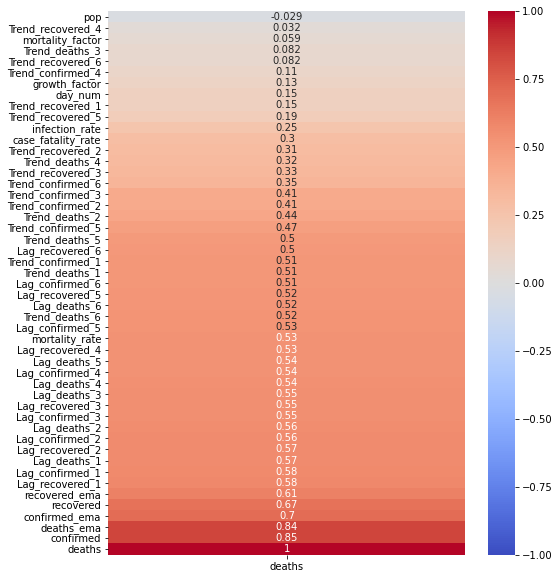

In [17]:
# check correlations with Deaths
heatmap_numeric_w_dependent_variable(covid_df_corr, 'deaths')

We find that there is a bunch of auto-correlations between fatal cases (*deaths*) and a number of derived lag/trend features. Namely, the following feature variables show strong correlations with _deaths_ cases

- confirmed
- recovered
- Lag_confirmed_1
- Lag_confirmed_2
- Lag_confirmed_3
- Lag_confirmed_4
- Lag_confirmed_5
- Lag_deaths_1
- Lag_deaths_2
- Lag_deaths_3
- Lag_deaths_4
- Lag_deaths_5
- Lag_deaths_6
- Lag_recovered_1
- Lag_recovered_2
- Lag_recovered_3
- Lag_recovered_4
- Trend_confirmed_1
- Trend_deaths_1
- Trend_deaths_5
- Trend_deaths_6
- confirmed_ema
- deaths_ema
- recovered_ema
- mortality_rate

## More Detailed Outlook on Correlations with Deaths

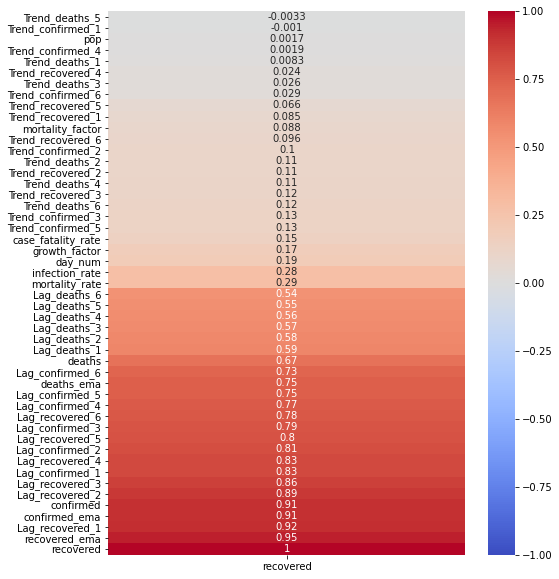

In [18]:
# check correlations with Recovered
heatmap_numeric_w_dependent_variable(covid_df_corr, 'recovered')

We find that the following feature variables display the strong and mediumm correlation with the number of _recovered_ cases

- confirmed
- deaths              
- Lag_confirmed_1
- Lag_confirmed_2
- Lag_confirmed_3
- Lag_confirmed_4
- Lag_confirmed_5
- Lag_confirmed_6
- Lag_deaths_1
- Lag_deaths_2
- Lag_deaths_3
- Lag_deaths_4
- Lag_deaths_5
- Lag_deaths_6
- Lag_recovered_1
- Lag_recovered_2
- Lag_recovered_3
- Lag_recovered_4
- Lag_recovered_5
- Lag_recovered_6
- confirmed_ema
- deaths_ema
- recovered_ema

# Google Mobility Trend Data

We are going to extract aggregated Google Mobility trend report data from a public dataset in BigQuery (namely, **bigquery-public-data.covid19_google_mobility** dataset, **mobility_report** table)

We are going to fetch the aggregated data from it with the columns described below

<table>
<thead>
<td>Field name</td><td>Type</td><td>Mode</td><td>Description</td>
</thead>
<tr>
<td>country_region_code</td><td>STRING</td><td>NULLABLE</td>
<td>2 letter alpha code for the country/region in which changes are measured relative to the baseline. These values correspond with the ISO 3166-1 alpha-2 codes</td>
</tr>
<tr>
<td>country_region</td><td>STRING</td><td>NULLABLE</td>	
<td>The country/region in which changes are measured relative to the baseline</td>
</td>
<tr>
<td>covid_date</td><td>DATE</td><td>NULLABLE</td><td>
Changes for a given date as compared to baseline. Baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.</td>
</tr>
<tr>
<td>retail_and_recreation_percent_change_from_baseline</td><td>INTEGER</td><td>NULLABLE</td><td>Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.</td>
</tr>
<tr>
<td>grocery_and_pharmacy_percent_change_from_baseline</td><td>INTEGER</td><td>NULLABLE</td><td>Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.</td>
</tr>
<tr>
<td>parks_percent_change_from_baseline</td><td>INTEGER</td><td>NULLABLE</td><td>Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.</td>
</tr>
<tr>
<td>transit_stations_percent_change_from_baseline</td><td>INTEGER</td><td>NULLABLE</td><td>Mobility trends for places like public transport hubs such as subway, bus, and train stations.</td>
</tr>
<tr>
<td>workplaces_percent_change_from_baseline</td><td>INTEGER</td><td>NULLABLE</td><td>Mobility trends for places of work.</td>
</tr>
<tr>
<td>residential_percent_change_from_baseline</td><td>INTEGER</td><td>NULLABLE</td><td>Mobility trends for places of residence.</td>
</tr>
</table>

**Note:** To learn more about the dataset, please refer to the data documentation on Google site: https://www.google.com/covid19/mobility/data_documentation.html

In [19]:
# I am going to extract data from BigQuery

def debugLogSQL(sql):
     print (' '.join([line.strip() for line in sql.splitlines()]).strip())

# SQL Query for aggregated mobility trend data
sql = """
  SELECT
  country_region_code as country_id, 
  date as covid_date,
  ROUND(AVG(retail_and_recreation_percent_change_from_baseline), 4) as retail_and_recreation_percent_change_from_baseline, 
  ROUND(AVG(grocery_and_pharmacy_percent_change_from_baseline), 4) as grocery_and_pharmacy_percent_change_from_baseline,
  ROUND(AVG(parks_percent_change_from_baseline), 4) as parks_percent_change_from_baseline,
  ROUND(AVG(transit_stations_percent_change_from_baseline), 4) as transit_stations_percent_change_from_baseline,
  ROUND(AVG(workplaces_percent_change_from_baseline), 4) as workplaces_percent_change_from_baseline,
  ROUND(AVG(residential_percent_change_from_baseline), 4) as residential_percent_change_from_baseline
  FROM `bigquery-public-data.covid19_google_mobility.mobility_report`
  GROUP BY country_region_code, date
"""
# debugLogSQL(sql)

# Set up the query
query_job = client.query(sql)

# Make an API request  to run the query and return a pandas DataFrame
google_mobility_df = query_job.to_dataframe()

# Note: the commented code below will be useful if you run a stand-alone notebook on either your premise or in Google Collab
# google_mobility_df = pd.read_gbq(sql, project_id=your_project_id, credentials=credentials, dialect='standard')

display(google_mobility_df.tail())

country_id  covid_date  \
17005         ZM  2020-06-15   
17006         ZM  2020-06-16   
17007         ZM  2020-06-17   
17008         ZM  2020-06-18   
17009         ZM  2020-06-19   

       retail_and_recreation_percent_change_from_baseline  \
17005                                               -6.0    
17006                                               -5.0    
17007                                               -5.0    
17008                                               -6.0    
17009                                               -7.0    

       grocery_and_pharmacy_percent_change_from_baseline  \
17005                                               -1.0   
17006                                                0.0   
17007                                                2.0   
17008                                                1.0   
17009                                               -3.0   

       parks_percent_change_from_baseline  \
17005                                 0.0   
17006                                 1.0   
17007                                 3.0   
17008                                 1.0   
17009                                 2.0   

       transit_stations_percent_change_from_baseline  \
17005                                          -12.0   
17006                                          -10.0   
17007                                           -9.0   
17008                                          -10.0   
17009                                          -12.0   

       workplaces_percent_change_from_baseline  \
17005                                     -1.0   
17006                                     -2.0   
17007                                     -3.0   
17008                                     -4.0   
17009                                      0.0   

       residential_percent_change_from_baseline  
17005                                      10.0  
17006                                       9.0  
17007                                       9.0  
17008                                       8.0  
17009                                       9.0

## Basic Google Mobility Trends Review

After we fetched the data from BigQuery, let's take a look at some basic mobile trend data.

The structure of the mobile trend data is described below

In [20]:
display(google_mobility_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 8 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   country_id                                          17010 non-null  object 
 1   covid_date                                          17010 non-null  object 
 2   retail_and_recreation_percent_change_from_baseline  16860 non-null  float64
 3   grocery_and_pharmacy_percent_change_from_baseline   16817 non-null  float64
 4   parks_percent_change_from_baseline                  16797 non-null  float64
 5   transit_stations_percent_change_from_baseline       16878 non-null  float64
 6   workplaces_percent_change_from_baseline             16965 non-null  float64
 7   residential_percent_change_from_baseline            16513 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.0+ MB


None

Let's describe the basic stat characteristics of the mobility trends data

In [21]:
google_mobility_df.describe()

retail_and_recreation_percent_change_from_baseline  \
count                                       16860.000000    
mean                                          -32.011459    
std                                            27.883798    
min                                           -98.333300    
25%                                           -54.673950    
50%                                           -29.384600    
75%                                            -6.000000    
max                                            60.000000    

       grocery_and_pharmacy_percent_change_from_baseline  \
count                                       16817.000000   
mean                                          -15.462712   
std                                            22.918572   
min                                           -98.500000   
25%                                           -28.000000   
50%                                           -10.000000   
75%                                             1.074100   
max                                            85.000000   

       parks_percent_change_from_baseline  \
count                        16797.000000   
mean                           -13.125797   
std                             38.135184   
min                           -100.000000   
25%                            -37.000000   
50%                            -14.000000   
75%                              3.000000   
max                            402.750000   

       transit_stations_percent_change_from_baseline  \
count                                   16878.000000   
mean                                      -35.447731   
std                                        27.433889   
min                                      -100.000000   
25%                                       -57.567450   
50%                                       -37.000000   
75%                                       -10.500000   
max                                        37.000000   

       workplaces_percent_change_from_baseline  \
count                             16965.000000   
mean                                -23.057683   
std                                  24.218305   
min                                 -92.000000   
25%                                 -41.400000   
50%                                 -21.000000   
75%                                  -1.294100   
max                                  70.000000   

       residential_percent_change_from_baseline  
count                              16513.000000  
mean                                  12.358536  
std                                   10.526529  
min                                  -16.000000  
25%                                    2.629600  
50%                                   11.928600  
75%                                   19.400000  
max                                   55.000000

As we can see, there are extreme cases of both the drastic decrease and drastic increase in the certain types of people mobility during the COVID-19 pandemic/quarantine. So it would be nice to explore it in more details down the road.

Let's now look at the mean values of each trend attribute by countries

In [22]:
google_mobility_df.groupby('country_id').mean()

retail_and_recreation_percent_change_from_baseline  \
country_id                                                       
AE                                                 -33.593254    
AF                                                 -30.785714    
AG                                                 -33.630952    
AO                                                 -28.537037    
AR                                                 -54.214286    
...                                                       ...    
VN                                                 -24.010547    
YE                                                  -6.666667    
ZA                                                 -37.865079    
ZM                                                  -9.182540    
ZW                                                 -30.418654    

            grocery_and_pharmacy_percent_change_from_baseline  \
country_id                                                      
AE                                                 -14.369048   
AF                                                 -15.730159   
AG                                                 -20.619048   
AO                                                 -13.896827   
AR                                                 -21.932063   
...                                                       ...   
VN                                                 -10.702371   
YE                                                  -0.015873   
ZA                                                 -20.484127   
ZM                                                  -3.746032   
ZW                                                 -18.288357   

            parks_percent_change_from_baseline  \
country_id                                       
AE                                  -42.882084   
AF                                  -14.031746   
AG                                  -21.472222   
AO                                  -24.341270   
AR                                  -63.802857   
...                                        ...   
VN                                  -21.824595   
YE                                   -7.793651   
ZA                                  -22.566667   
ZM                                   -0.492063   
ZW                                  -28.189153   

            transit_stations_percent_change_from_baseline  \
country_id                                                  
AE                                             -42.313493   
AF                                             -31.896825   
AG                                             -45.354494   
AO                                             -39.883599   
AR                                             -50.755582   
...                                                   ...   
VN                                             -21.410987   
YE                                              -8.071429   
ZA                                             -41.500794   
ZM                                             -13.031746   
ZW                                             -44.132934   

            workplaces_percent_change_from_baseline  \
country_id                                            
AE                                       -24.822421   
AF                                       -24.373016   
AG                                       -35.439551   
AO                                       -13.564817   
AR                                       -24.029524   
...                                             ...   
VN                                         2.789809   
YE                                        -5.277778   
ZA                                       -29.286508   
ZM                                        -4.246032   
ZW                                       -17.146019   

            residential_percent_change_from_baseline  
country_id                                            
AE                                  

## EDA of Mobility Trend Data

### Missing Values

First of all, we will review the number of missing values (NAs) in each attributes of Google Mobility Trend dataset

In [23]:
# Missing value summary
nan_columns = []
nan_values = []

for column in google_mobility_df.columns:
    nan_columns.append(column)
    nan_values.append(google_mobility_df[column].isnull().sum())

fig = go.Figure(go.Bar(
            x=nan_columns,
            y=nan_values,
            orientation='v'))

fig.update_layout(
    title='Missing Values in Google Mobility Trend Attributes',
    xaxis_title="Column names",
    yaxis_title="Number of Missing values"
)

fig.show()

As we can see, *residential_percent_change_from_baseline* has the biggest amount of NAs within the dataset attributes yet none of the features has the ratio of NaNs exceeding 10% of the population (which is definitely an indicator of a reasonably good quality of the input data, from NaN perspective).

After it, let's review the distribution of NA values by country.

In [24]:
country_na = google_mobility_df.groupby('country_id').count().rsub(google_mobility_df.groupby('country_id').size(), axis=0)

Let's see the top countries where the most of NA values in *retail_and_recreation_percent_change_from_baseline* attribute are present

In [25]:
country_na.sort_values('retail_and_recreation_percent_change_from_baseline', 
                   ascending=False)[
                        [ 
                          'retail_and_recreation_percent_change_from_baseline'
                        ]
                              ][:10].style.background_gradient(cmap='Oranges')

As we can see, GW (Guinea-Bissau) and LI (Liechtenstein) lead the list of countries with missing values for *retail_and_recreation_percent_change_from_baseline*, and the third country to have some NAs for this feature is RE (Réunion island, the French department in Indian ocean). So we can conclude the overall quality of *retail_and_recreation_percent_change_from_baseline* data is quite good.

Below is the outlook on NA values in *grocery_and_pharmacy_percent_change_from_baseline* by country

In [26]:
country_na.sort_values('grocery_and_pharmacy_percent_change_from_baseline', 
                   ascending=False)[
                                    [ 
                                     'grocery_and_pharmacy_percent_change_from_baseline'
                                    ]
                                  ][:10].style.background_gradient(cmap='Oranges')

As we can see, the same 3 countries have some missing data for *grocery_and_pharmacy_percent_change_from_baseline*, and the rest of the countries has no missing values for this feature. So we can conclude the overall quality of *grocery_and_pharmacy_percent_change_from_baseline* data is quite good.

Below is the outlook on NA values in *parks_percent_change_from_baseline* by country

In [27]:
country_na.sort_values('parks_percent_change_from_baseline', 
        ascending=False)[
                                [ 
                                  'parks_percent_change_from_baseline'
                                ]
                          ][:10].style.background_gradient(cmap='Oranges')

As we can see, the same 3 countries have some missing data for *parks_percent_change_from_baseline*, and the rest of the countries has no missing values for this feature. So we can conclude the overall quality of *parks_percent_change_from_baseline* data is quite good.

Below is the outlook on NA values for *transit_stations_percent_change_from_baseline* 

In [28]:
country_na.sort_values('transit_stations_percent_change_from_baseline', 
        ascending=False)[
                            [ 
                              'transit_stations_percent_change_from_baseline'
                            ]
                          ][:10].style.background_gradient(cmap='Oranges')

As we can see, only 2 countries - GW (Guinea-Bissau) and LI (Liechtenstein) - have some missing data for *transit_stations_percent_change_from_baseline*, and the rest of the countries has no missing values for this feature. So we can conclude the overall quality of *transit_stations_percent_change_from_baseline* data is quite good.

Below is the outlook on NA values for *workplaces_percent_change_from_baseline*

In [29]:
country_na.sort_values('workplaces_percent_change_from_baseline', 
        ascending=False)[
                            [ 
                              'workplaces_percent_change_from_baseline'
                            ]
                          ][:10].style.background_gradient(cmap='Oranges')

As we can see, only 2 countries - GW (Guinea-Bissau) and LI (Liechtenstein) - have some missing data for *workplaces_percent_change_from_baseline*, and the rest of the countries has no missing values for this feature. So we can conclude the overall quality of *workplaces_percent_change_from_baseline* data is quite good.

Below is the outlook on NA values for *residential_percent_change_from_baseline*

In [30]:
country_na.sort_values('residential_percent_change_from_baseline', 
        ascending=False)[
                            [ 
                              'residential_percent_change_from_baseline'
                            ]
                          ][:11].style.background_gradient(cmap='Oranges')

As we can see, there 10 countries with missing data for *residential_percent_change_from_baseline* feature (with GW (Guinea-Bissau), RE (Reunion Island) and LI (Liechtenstein) leading the charts, again). So the quality of data for this feature is a little worse then for the rest of the features in the dataset (yet still good enough).

**Missing Data Summary**

As we can see, the Google Trends data are inconsistent for three countries below

- LI
- GW
- RE

In addition to it, there is a number of contries with a small number of missing values for *residential_percent_change_from_baseline*, as per the list below

- AG
- AW
- CV
- PG
- BZ
- BB
- LU

We can also see the lack of data for several countries (China, Northen Korea etc.) in Google Mobility Trends dataset (due to some legal restrictions or complex technical issues, most probably).

For the rest of the countries all 6 attributes from Google Mobility Trends dataset are fully supplied.

**Note**: The information for Russia and Ukraine have been added quite recently, sometime after Jun 10, 2020 (which is definitely a good indicator)

### Individual Feature Inspection

#### Inspection of retail_and_recreation_percent_change_from_baseline

In [31]:
fig = px.histogram(google_mobility_df, 
                   x="retail_and_recreation_percent_change_from_baseline", 
                   marginal="violin", # or  box, rug
                   )
fig.show()

Based on the histogram above, we can see that 
- the median of the deviation from the pre-pandemic trend for *retail and recreation area* visiting is -31,25% (accross all of the country/observation date pairs within the observation interval)
- there are extreme peak values on both ends of the distribution (like -98.33% or +60%) that indicate the interesting edge cases to investigate in a country-by-country manner

Now let's look at the top 20 countries where the largest deviations of *retail_and_recreation_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [32]:
max_df = google_mobility_df.groupby('country_id')['retail_and_recreation_percent_change_from_baseline'].max().reset_index()

max_df.sort_values('retail_and_recreation_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id', 
                                     'retail_and_recreation_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Oranges')

We can see that the countries below have the maximal extreme positive deviations of *retail_and_recreation_percent_change_from_baseline*:

In [33]:
df_in = max_df.sort_values('retail_and_recreation_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id']
                                  ][:20]

retail_and_recreation_percent_change_from_baseline_max = df_in['country_id'].to_list()

print(retail_and_recreation_percent_change_from_baseline_max, end= " ")

['LI', 'TT', 'EE', 'LV', 'HU', 'GR', 'IL', 'LY', 'KZ', 'PT', 'SE', 'MN', 'PL', 'UA', 'KG', 'JP', 'SI', 'BG', 'RU', 'NA'] 

Now let's look at the top 20 countries where the smallest deviations of *retail_and_recreation_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [34]:
min_df = google_mobility_df.groupby('country_id')['retail_and_recreation_percent_change_from_baseline'].min().reset_index()

min_df.sort_values('retail_and_recreation_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id', 
                                     'retail_and_recreation_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Blues')

We can see that the countries below have the maximal extreme negative deviations of *retail_and_recreation_percent_change_from_baseline*

In [35]:
df_in = min_df.sort_values('retail_and_recreation_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id']
                                  ][:20]

retail_and_recreation_percent_change_from_baseline_min = df_in['country_id'].to_list()

print(retail_and_recreation_percent_change_from_baseline_min, end= " ")

['BS', 'RE', 'MU', 'RS', 'NZ', 'AW', 'PA', 'ES', 'BB', 'IT', 'IL', 'AG', 'PR', 'PE', 'MK', 'SI', 'BO', 'BZ', 'LU', 'SK'] 

Worldwide history of changes in Retail and Recreation Area Visits is displayed below

In [36]:
formated_gdf = google_mobility_df.fillna(0).groupby(['covid_date', 'country_id'])['retail_and_recreation_percent_change_from_baseline'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')

country_size_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('retail_and_recreation_percent_change_from_baseline', 
                    set_size, 'size', drop=False)
])

formated_gdf = country_size_pipeline.apply(formated_gdf)

formated_gdf.fillna(0, inplace=True)

formated_gdf = country_name_pipeline.apply(formated_gdf)

In [37]:
fig = px.scatter_geo(
    formated_gdf, locations="country_id", locationmode='country names', 
    color="retail_and_recreation_percent_change_from_baseline", 
    size='size', hover_name="country_id", 
    range_color= [-100, 20], 
    projection="natural earth", animation_frame="covid_date", 
    title='Google Mobility Trend: Changes in Retail and Recreation Area Visits Over Time', 
    color_continuous_scale="portland")

fig.show()

#### Inspection of workplaces_percent_change_from_baseline inspection

First of all, let's check the distribution of this variable via its histogram

In [38]:
fig = px.histogram(google_mobility_df, 
                   x="workplaces_percent_change_from_baseline", 
                   marginal="violin", # or  box, rug
                   )
fig.show()

Based on the histogram above, we can see that 
- the median of the deviation from the pre-pandemic trend for *office and workdplace area* visiting is -22% (accross all of the country/observation date pairs within the observation interval)
- there are extreme peak values on both ends of the distribution histogram (like -92% or +56%) that indicate the interesting edge cases to investigate in a country-by-country manner

Now let's look at the top 20 countries where the largest deviations of *workplaces_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [39]:
max_df = google_mobility_df.groupby('country_id')['workplaces_percent_change_from_baseline'].max().reset_index()

max_df.sort_values('workplaces_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id', 
                                     'workplaces_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Oranges')

We can see that the countries below have the maximal extreme positive deviations of *workplaces_percent_change_from_baseline*

In [40]:
df_in = max_df.sort_values('workplaces_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id']
                                  ][:20]

workplaces_percent_change_from_baseline_max = df_in['country_id'].to_list()

print(workplaces_percent_change_from_baseline_max, end= " ")

['LV', 'TW', 'BY', 'MU', 'VN', 'FI', 'UY', 'RO', 'PG', 'MZ', 'BO', 'ML', 'TJ', 'AR', 'LT', 'CR', 'CO', 'NZ', 'MK', 'MN'] 

Now let's look at the top 20 countries where the smallest deviations of *workplaces_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [41]:
min_df = google_mobility_df.groupby('country_id')['workplaces_percent_change_from_baseline'].min().reset_index()

min_df.sort_values('workplaces_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id', 
                                     'workplaces_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Blues')

We can see that the countries below have the maximal extreme negative deviations of *workplaces_percent_change_from_baseline*

In [42]:
df_in = min_df.sort_values('workplaces_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id']
                                  ][:20]

workplaces_percent_change_from_baseline_min = df_in['country_id'].to_list()

print(workplaces_percent_change_from_baseline_min, end= " ")

['LU', 'RS', 'IL', 'AW', 'AG', 'BB', 'LI', 'MK', 'MU', 'IT', 'FR', 'ES', 'BE', 'PL', 'AT', 'DE', 'SK', 'SI', 'PA', 'BZ'] 

The worldwide history of the Changes in Workplace and Office Center Visits is displayed below

In [43]:
formated_gdf = google_mobility_df.fillna(0).groupby(['covid_date', 'country_id'])['workplaces_percent_change_from_baseline'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')

country_size_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('workplaces_percent_change_from_baseline', 
                    set_size, 'size', drop=False)
])

formated_gdf = country_size_pipeline.apply(formated_gdf)

formated_gdf.fillna(0, inplace=True)

formated_gdf = country_name_pipeline.apply(formated_gdf)

In [44]:
fig = px.scatter_geo(
    formated_gdf, locations="country_id", locationmode='country names', 
    color="workplaces_percent_change_from_baseline", 
    size='size', hover_name="country_id", 
    range_color= [-100, 20], 
    projection="natural earth", animation_frame="covid_date", 
    title='Google Mobility Trend: Changes in Workplace and Office Center Visits Over Time', 
    color_continuous_scale="portland")

fig.show()

#### Inspection of grocery_and_pharmacy_percent_change_from_baseline

In [45]:
fig = px.histogram(google_mobility_df, 
                   x="grocery_and_pharmacy_percent_change_from_baseline", 
                   marginal="violin", # or  box, rug
                   )
fig.show()

Based on the histogram above, we can see that 
- the median of the deviation from the pre-pandemic trend for *grocery_and_pharmacy_percent_change_from_baseline* visiting is -11% (accross all of the country/observation date pairs within the observation interval)
- there are extreme peak values on both ends of the distribution histogram (like -98.5% or +85%) that indicate the interesting edge cases to investigate in a country-by-country manner
- we also see a bunch of outliers detected for *grocery_and_pharmacy_percent_change_from_baseline* - it will be interesting to delve into such extreme deviations in the country-by-country manner down the road

Now let's look at the top 20 countries where the largest deviations of *grocery_and_pharmacy_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [46]:
max_df = google_mobility_df.groupby('country_id')['grocery_and_pharmacy_percent_change_from_baseline'].max().reset_index()

max_df.sort_values('grocery_and_pharmacy_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id', 
                                     'grocery_and_pharmacy_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Oranges')

We can see that the countries below have the maximal extreme positive deviations of *grocery_and_pharmacy_percent_change_from_baseline*

In [47]:
df_in = max_df.sort_values('grocery_and_pharmacy_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id']
                                  ][:20]

grocery_and_pharmacy_percent_change_from_baseline_max = df_in['country_id'].to_list()

print(grocery_and_pharmacy_percent_change_from_baseline_max, end= " ")

['PL', 'GR', 'MN', 'TR', 'LY', 'ZA', 'NO', 'LU', 'IL', 'FI', 'AT', 'FR', 'MU', 'SE', 'LT', 'DE', 'AW', 'AF', 'JO', 'HR'] 

Now let's look at the top 20 countries where the smallest deviations of *grocery_and_pharmacy_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [48]:
min_df = google_mobility_df.groupby('country_id')['grocery_and_pharmacy_percent_change_from_baseline'].min().reset_index()

min_df.sort_values('grocery_and_pharmacy_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id', 
                                     'grocery_and_pharmacy_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Blues')

We can see that the countries below have the maximal extreme negative deviations of *grocery_and_pharmacy_percent_change_from_baseline*

In [49]:
df_in = min_df.sort_values('grocery_and_pharmacy_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id']
                                  ][:20]

grocery_and_pharmacy_percent_change_from_baseline_min = df_in['country_id'].to_list()

print(grocery_and_pharmacy_percent_change_from_baseline_min, end= " ")

['BS', 'BB', 'PR', 'RS', 'AW', 'RE', 'AG', 'MU', 'BO', 'PA', 'MK', 'SI', 'BZ', 'LU', 'PE', 'AT', 'PL', 'IT', 'DE', 'RO'] 

The worldwide history of the Changes in Grocery and Pharmacy Visits is displayed below

In [50]:
formated_gdf = google_mobility_df.fillna(0).groupby(['covid_date', 'country_id'])['grocery_and_pharmacy_percent_change_from_baseline'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')

country_size_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('grocery_and_pharmacy_percent_change_from_baseline', 
                    set_size, 'size', drop=False)
])

formated_gdf = country_size_pipeline.apply(formated_gdf)

formated_gdf.fillna(0, inplace=True)

formated_gdf = country_name_pipeline.apply(formated_gdf)

In [51]:
fig = px.scatter_geo(
    formated_gdf, locations="country_id", locationmode='country names', 
    color="grocery_and_pharmacy_percent_change_from_baseline", 
    size='size', hover_name="country_id", 
    range_color= [-100, 20], 
    projection="natural earth", animation_frame="covid_date", 
    title='Google Mobility Trend: Changes in Grocery and Pharmacy Visits Over Time', 
    color_continuous_scale="portland")

fig.show()

#### Inspection of parks_percent_change_from_baseline

In [52]:
fig = px.histogram(google_mobility_df, 
                   x="parks_percent_change_from_baseline", 
                   marginal="violin", # or  box, rug
                   )
fig.show()

Based on the histogram above, we can see that 
- the median of the deviation from the pre-pandemic trend for *parks_percent_change_from_baseline* visiting is -14% (accross all of the country/observation date pairs within the observation interval)
- there are extreme peak values on both ends of the distribution histogram (like -100% or +358%) that indicate the interesting edge cases to investigate in a country-by-country manner
- we also see a bunch of outliers detected for *parks_percent_change_from_baseline* - it will be interesting to delve into such extreme deviations in the country-by-country manner down the road

Now let's look at the top 20 countries where the largest deviations of *parks_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [53]:
max_df = google_mobility_df.groupby('country_id')['parks_percent_change_from_baseline'].max().reset_index()

max_df.sort_values('parks_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id', 
                                     'parks_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Oranges')

We can see that the countries below have the maximal extreme positive deviations of *parks_percent_change_from_baseline*

In [54]:
df_in = max_df.sort_values('parks_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id']
                                  ][:20]

parks_percent_change_from_baseline_max = df_in['country_id'].to_list()

print(parks_percent_change_from_baseline_max, end= " ")

['FI', 'DK', 'NO', 'NL', 'DE', 'SE', 'PL', 'LT', 'GR', 'EE', 'CA', 'KR', 'TT', 'HU', 'LU', 'AT', 'CZ', 'BE', 'IT', 'SK'] 

Now let's look at the top 20 countries where the smallest deviations of *parks_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [55]:
min_df = google_mobility_df.groupby('country_id')['parks_percent_change_from_baseline'].min().reset_index()

min_df.sort_values('parks_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id', 
                                     'parks_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Blues')

We can see that the countries below have the maximal extreme negative deviations of *parks_percent_change_from_baseline*

In [56]:
df_in = min_df.sort_values('parks_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id']
                                  ][:20]

parks_percent_change_from_baseline_min = df_in['country_id'].to_list()

print(parks_percent_change_from_baseline_min, end= " ")

['RE', 'AR', 'BB', 'MU', 'IT', 'ES', 'AW', 'BO', 'PA', 'RS', 'CR', 'PE', 'PR', 'BS', 'PT', 'NZ', 'AE', 'EC', 'KW', 'AG'] 

The worldwide history of the Changes in Park Visits is displayed below

In [57]:
formated_gdf = google_mobility_df.fillna(0).groupby(['covid_date', 'country_id'])['parks_percent_change_from_baseline'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')

country_size_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('parks_percent_change_from_baseline', 
                    set_size, 'size', drop=False)
])

formated_gdf = country_size_pipeline.apply(formated_gdf)

formated_gdf.fillna(0, inplace=True)

formated_gdf = country_name_pipeline.apply(formated_gdf)

In [58]:
fig = px.scatter_geo(
    formated_gdf, locations="country_id", locationmode='country names', 
    color="parks_percent_change_from_baseline", 
    size='size', hover_name="country_id", 
    range_color= [-100, 20], 
    projection="natural earth", animation_frame="covid_date", 
    title='Google Mobility Trend: Changes in Park Visits Over Time', 
    color_continuous_scale="portland")

fig.show()

#### Inspection of transit_stations_percent_change_from_baseline

In [59]:
fig = px.histogram(google_mobility_df, 
                   x="transit_stations_percent_change_from_baseline",  
                   marginal="violin", # or  box, rug
                   )
fig.show()

Based on the histogram above, we can see that 
- the median of the deviation from the pre-pandemic trend for *transit_stations_percent_change_from_baseline* visiting is -38% (accross all of the country/observation date pairs within the observation interval)
- there are extreme peak values on both ends of the distribution histogram (like -100% or +37%) that indicate the interesting edge cases to investigate in a country-by-country manner

Now let's look at the top 20 countries where the largest deviations of *transit_stations_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [60]:
max_df = google_mobility_df.groupby('country_id')['transit_stations_percent_change_from_baseline'].max().reset_index()

max_df.sort_values('transit_stations_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id', 
                                     'transit_stations_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Oranges')

We can see that the countries below have the maximal extreme positive deviations of *transit_stations_percent_change_from_baseline*

In [61]:
df_in = max_df.sort_values('transit_stations_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id']
                                  ][:20]

transit_stations_percent_change_from_baseline_max = df_in['country_id'].to_list()

print(transit_stations_percent_change_from_baseline_max, end= " ")

['LI', 'OM', 'HR', 'TT', 'AW', 'EE', 'SI', 'KZ', 'MN', 'PT', 'GR', 'RW', 'BS', 'FR', 'CH', 'HU', 'IN', 'RE', 'BY', 'IQ'] 

Now let's look at the top 20 countries where the smallest deviations of *transit_stations_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [62]:
min_df = google_mobility_df.groupby('country_id')['transit_stations_percent_change_from_baseline'].min().reset_index()

min_df.sort_values('transit_stations_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id', 
                                     'transit_stations_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Blues')

We can see that the countries below have the maximal extreme negative deviations of *parks_percent_change_from_baseline*

In [63]:
df_in = min_df.sort_values('transit_stations_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id']
                                  ][:20]

transit_stations_percent_change_from_baseline_min = df_in['country_id'].to_list()

print(transit_stations_percent_change_from_baseline_min, end= " ")

['BS', 'BZ', 'AG', 'BB', 'JO', 'MK', 'RS', 'BO', 'MU', 'PE', 'AW', 'GT', 'RE', 'CR', 'ES', 'PA', 'EC', 'PR', 'IT', 'CV'] 

The worldwide history of the Changes in Park Visits is displayed below

In [64]:
formated_gdf = google_mobility_df.fillna(0).groupby(['covid_date', 'country_id'])['transit_stations_percent_change_from_baseline'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')

country_size_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('transit_stations_percent_change_from_baseline', 
                    set_size, 'size', drop=False)
])

formated_gdf = country_size_pipeline.apply(formated_gdf)

formated_gdf.fillna(0, inplace=True)

formated_gdf = country_name_pipeline.apply(formated_gdf)

In [65]:
fig = px.scatter_geo(
    formated_gdf, locations="country_id", locationmode='country names', 
    color="transit_stations_percent_change_from_baseline", 
    size='size', hover_name="country_id", 
    range_color= [-100, 20], 
    projection="natural earth", animation_frame="covid_date", 
    title='Google Mobility Trend: Changes in Transit Station Visits Over Time', 
    color_continuous_scale="portland")

fig.show()

#### Inspection of residential_percent_change_from_baseline

In [66]:
fig = px.histogram(google_mobility_df, 
                   x="residential_percent_change_from_baseline", 
                   marginal="violin", # or  box, rug
                   )
fig.show()

Based on the histogram above, we can see that 
- the median of the deviation from the pre-pandemic trend for *residential_percent_change_from_baseline* visiting is +12% (accross all of the country/observation date pairs within the observation interval)
- there are extreme peak values on both ends of the distribution histogram (like -7% or +55%) that indicate the interesting edge cases to investigate in a country-by-country manner
- there is a bunch of outliers detected for *residential_percent_change_from_baseline*, which is also interesting to delve into down the road

Now let's look at the top 20 countries where the largest deviations of *transit_stations_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [67]:
max_df = google_mobility_df.groupby('country_id')['residential_percent_change_from_baseline'].max().reset_index()

max_df.sort_values('residential_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id', 
                                     'residential_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Oranges')

We can see that the countries below have the maximal extreme positive deviations of *residential_percent_change_from_baseline*

In [68]:
df_in = max_df.sort_values('residential_percent_change_from_baseline', 
                   ascending=False)[
                                    ['country_id']
                                  ][:20]

residential_percent_change_from_baseline_max = df_in['country_id'].to_list()

print(residential_percent_change_from_baseline_max, end= " ")

['SG', 'BW', 'ZW', 'BS', 'PA', 'PE', 'LK', 'PT', 'SV', 'BO', 'KW', 'LU', 'PY', 'PR', 'BB', 'GT', 'ZA', 'EC', 'ES', 'NZ'] 

Now let's look at the top 20 countries where the smallest deviations of *transit_stations_percent_change_from_baseline* observed on any of the dates within the pandemy interval

In [69]:
min_df = google_mobility_df.groupby('country_id')['residential_percent_change_from_baseline'].min().reset_index()

min_df.sort_values('residential_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id', 
                                     'residential_percent_change_from_baseline'
                                    ]
                                  ][:20].style.background_gradient(cmap='Blues')

We can see that the countries below have the maximal extreme negative deviations of *residential_percent_change_from_baseline*

In [70]:
df_in = min_df.sort_values('residential_percent_change_from_baseline', 
                   ascending=True)[
                                    ['country_id']
                                  ][:20]

residential_percent_change_from_baseline_min = df_in['country_id'].to_list()

print(residential_percent_change_from_baseline_min, end= " ")

['RS', 'GE', 'MN', 'LV', 'EE', 'LT', 'RU', 'BY', 'FI', 'SI', 'KG', 'TJ', 'UA', 'AF', 'NO', 'BG', 'HR', 'MD', 'NA', 'KZ'] 

The worldwide history of the Changes in Residential Area Visits is displayed below

In [71]:
formated_gdf = google_mobility_df.fillna(0).groupby(['covid_date', 'country_id'])['residential_percent_change_from_baseline'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['covid_date'] = pd.to_datetime(formated_gdf['covid_date'])
formated_gdf['covid_date'] = formated_gdf['covid_date'].dt.strftime('%m/%d/%Y')

country_size_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols('residential_percent_change_from_baseline', 
                    set_size, 'size', drop=False)
])

formated_gdf = country_size_pipeline.apply(formated_gdf)

formated_gdf.fillna(0, inplace=True)

formated_gdf = country_name_pipeline.apply(formated_gdf)

In [72]:
fig = px.scatter_geo(
    formated_gdf, locations="country_id", locationmode='country names', 
    color="residential_percent_change_from_baseline", 
    size='size', hover_name="country_id", 
    range_color= [-100, 20], 
    projection="natural earth", animation_frame="covid_date", 
    title='Google Mobility Trend: Changes in Residential Area Visits Over Time', 
    color_continuous_scale="portland")

fig.show()

### Correlation Analysis of Google Mobile Trend Features

We will check the correlation of the numeric variables globally

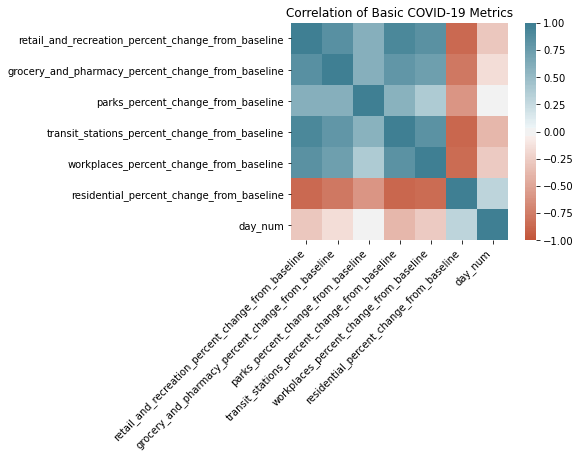

In [73]:
# Correlation of Mobility Trend variables
le = preprocessing.LabelEncoder()

google_mobility_df_corr = google_mobility_df.copy()
google_mobility_df_corr['day_num'] = le.fit_transform(google_mobility_df_corr.covid_date)
corr_transform_google_mobility = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id',
        'covid_date'     
    })
])


data = corr_transform_google_mobility.apply(google_mobility_df_corr)
corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation of Basic COVID-19 Metrics')
ax

I found that

- *residential_percent_change_from_baseline* has negative correlations with the rest of the Google Mobility Trend attributes - it draws a sense of wisdom here as the generic global lockdown and quarantine containment measures in the majority of the countries across the globe forced the populations to walk around their residential areas mainly while drastically reducing movements in other types of areas
- *parks_percent_change_from_baseline*, surprisingly, does not show any strong correlations with other features; we can explain it by the strong global beliefs in the power of fresh air and natural resorts toward struggling with viral infrections (Covid-19 inclusive); despite many countries specifically enforced ban on parks and natural areas visits as a part of the lockdown restrictions, people ignored on the large scale (however, there is a subset of countries where park visits drop was really dramatic - we are going to review it down the road below)
- the rest of Google Mobility Trend attributes displayed strong pair correlations that is in line with the common sense intuition - the global lockdown restrictions should have resulted in drop in visits/moves around all of the areas except the residential ones

# Correlation Between COVID-19 Pandemic Attirbutes and Google Mobility Trend Features

First of all, I will merge the dataframes with the COVID-19 pandemic attributes and Google Mobile Trend features into a single dataframe.

In [74]:
google_mobility_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 8 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   country_id                                          17010 non-null  object 
 1   covid_date                                          17010 non-null  object 
 2   retail_and_recreation_percent_change_from_baseline  16860 non-null  float64
 3   grocery_and_pharmacy_percent_change_from_baseline   16817 non-null  float64
 4   parks_percent_change_from_baseline                  16797 non-null  float64
 5   transit_stations_percent_change_from_baseline       16878 non-null  float64
 6   workplaces_percent_change_from_baseline             16965 non-null  float64
 7   residential_percent_change_from_baseline            16513 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.0+ MB


In [75]:
covid_df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34578 entries, 0 to 34577
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   country_id          34578 non-null  object        
 1   covid_date          34578 non-null  datetime64[ns]
 2   confirmed           34578 non-null  int64         
 3   deaths              34578 non-null  int64         
 4   recovered           34578 non-null  int64         
 5   pop                 34578 non-null  int64         
 6   day_num             34578 non-null  int64         
 7   Lag_confirmed_1     34578 non-null  int64         
 8   Lag_confirmed_2     34578 non-null  int64         
 9   Lag_confirmed_3     34578 non-null  int64         
 10  Lag_confirmed_4     34578 non-null  int64         
 11  Lag_confirmed_5     34578 non-null  int64         
 12  Lag_confirmed_6     34578 non-null  int64         
 13  Lag_deaths_1        34578 non-null  int64     

In [76]:
covid_date_pipeline = pdp.PdPipeline([
    pdp.ApplyByCols(['covid_date'], pd.to_datetime),
])

# merge COVID-19 and Google Trends Mobility Attributes

data_all = pd.merge(covid_df_corr,
                 covid_date_pipeline.apply(country_name_pipeline.apply(google_mobility_df)),
                 on=['country_id', 'covid_date'])

display(data_all.head(10))

country_id covid_date  confirmed  deaths  recovered       pop  day_num  \
0  Afghanistan 2020-02-15          0       0          0  37172386       24   
1  Afghanistan 2020-02-16          0       0          0  37172386       25   
2  Afghanistan 2020-02-17          0       0          0  37172386       26   
3  Afghanistan 2020-02-18          0       0          0  37172386       27   
4  Afghanistan 2020-02-19          0       0          0  37172386       28   
5  Afghanistan 2020-02-20          0       0          0  37172386       29   
6  Afghanistan 2020-02-21          0       0          0  37172386       30   
7  Afghanistan 2020-02-22          0       0          0  37172386       31   
8  Afghanistan 2020-02-23          0       0          0  37172386       32   
9  Afghanistan 2020-02-24          1       0          0  37172386       33   

   Lag_confirmed_1  Lag_confirmed_2  Lag_confirmed_3  ...  mortality_factor  \
0                0                0                0  ...               0.0   
1                0                0                0  ...               0.0   
2                0                0                0  ...               0.0   
3                0                0                0  ...               0.0   
4                0                0                0  ...               0.0   
5                0                0                0  ...               0.0   
6                0                0                0  ...               0.0   
7                0                0                0  ...               0.0   
8                0                0                0  ...               0.0   
9                0                0                0  ...               0.0   

   case_fatality_rate  infection_rate  mortality_rate  \
0                 0.0             0.0             0.0   
1                 0.0             0.0             0.0   
2                 0.0             0.0             0.0   
3                 0.0             0.0             0.0   
4                 0.0             0.0             0.0   
5                 0.0             0.0             0.0   
6                 0.0             0.0             0.0   
7                 0.0             0.0             0.0   
8                 0.0             0.0             0.0   
9                 0.0             0.0             0.0   

   retail_and_recreation_percent_change_from_baseline  \
0                                               -9.0    
1                                                3.0    
2                                                6.0    
3                                                3.0    
4                                               -1.0    
5                                               -2.0    
6                                                0.0    
7                                                2.0    
8                                                2.0    
9                                                3.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                              -10.0   
1                                               11.0   
2                                               11.0   
3                                                5.0   
4                                                3.0   
5                                                3.0   
6                                                9.0   
7                                                5.0   
8                                                6.0   
9                                               13.0   

   parks_percent_change_from_baseline  \
0                                 0.0   
1                                 1.0   
2                                 2.0   
3                                 3.0   
4                                 1.0   
5                                -1.0   
6                                 4.0   
7                                 6.0   
8                                

## Correlations with retail_and_recreation_percent_change_from_baseline

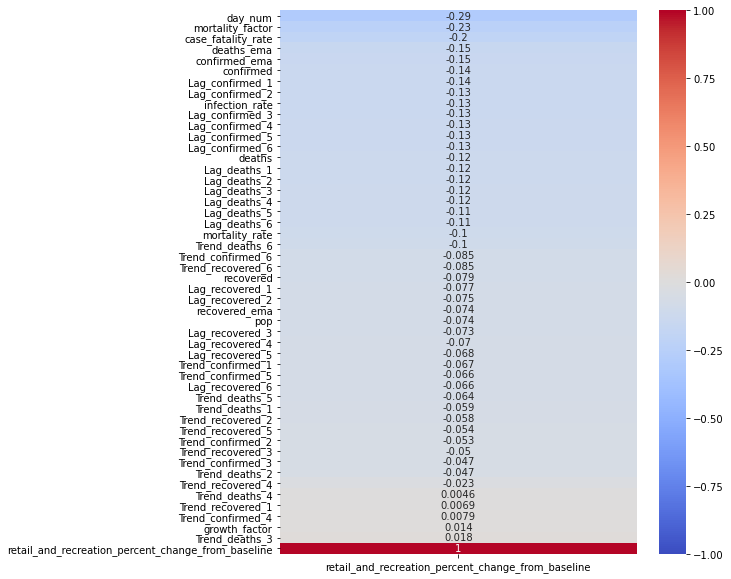

In [77]:
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id','covid_date',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    })
])

data_all_corr = corr_transform(data_all)

heatmap_numeric_w_dependent_variable(data_all_corr, 
                    'retail_and_recreation_percent_change_from_baseline')

We can observe medium negative correlations ( <= -0.2) between *retail_and_recreation_percent_change_from_baseline* and a number of COVID-19 pandemic spread features

- mortality_factor (-0.27)
- case_fatality_rate

## Correlations with grocery_and_pharmacy_percent_change_from_baseline

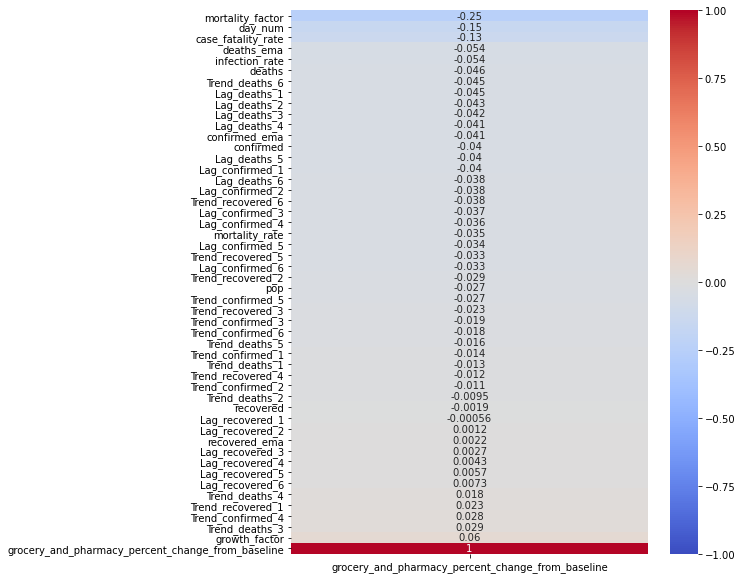

In [78]:
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id', 'covid_date',
        'retail_and_recreation_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    })
])

data_all_corr = corr_transform(data_all)

heatmap_numeric_w_dependent_variable(data_all_corr, 
              'grocery_and_pharmacy_percent_change_from_baseline')

We can observe medium negative correlations ( <= -0.2) between *grocery_and_pharmacy_percent_change_from_baseline* and a number of COVID-19 pandemic spread features

- mortality_factor (-0.3)

## Correlations with parks_percent_change_from_baseline

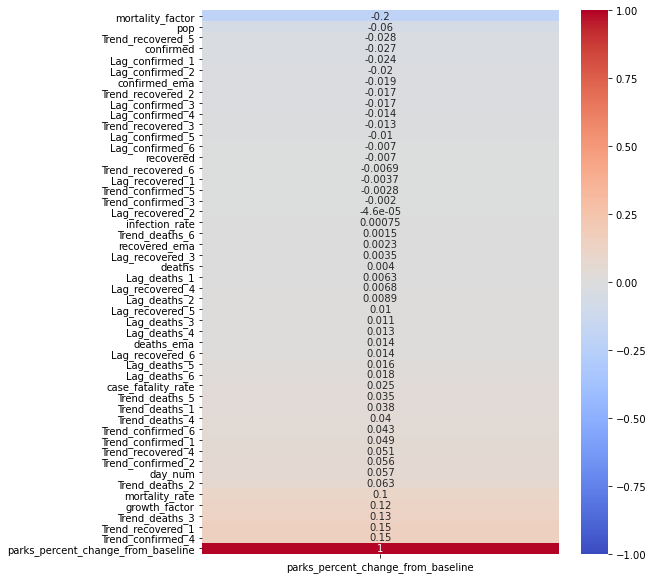

In [79]:
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id', 'covid_date',
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    })
])

data_all_corr = corr_transform(data_all)

heatmap_numeric_w_dependent_variable(data_all_corr, 
                    'parks_percent_change_from_baseline')

We can observe medium negative correlations ( <= -0.2) between *parks_percent_change_from_baseline* and a number of COVID-19 pandemic spread features

- mortality_factor (-0.24)

## Correlations with transit_stations_percent_change_from_baseline

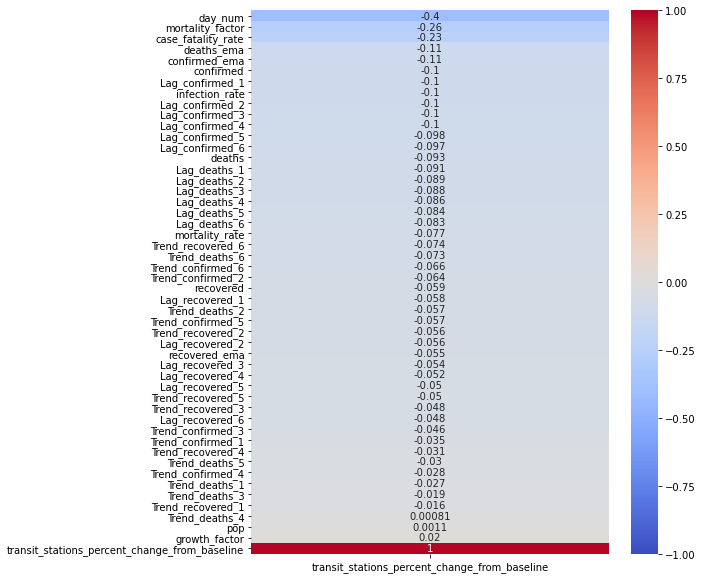

In [80]:
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id',	'covid_date',
        'retail_and_recreation_percent_change_from_baseline',	
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',	
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    })
])

data_all_corr = corr_transform(data_all)

heatmap_numeric_w_dependent_variable(data_all_corr, 
                    'transit_stations_percent_change_from_baseline')

We can observe medium negative correlations ( <= -0.2) between *transit_stations_percent_change_from_baseline* and a number of COVID-19 pandemic spread features

- mortality_factor (-0.3)
- case_fatality_rate

## Correlations with workplaces_percent_change_from_baseline

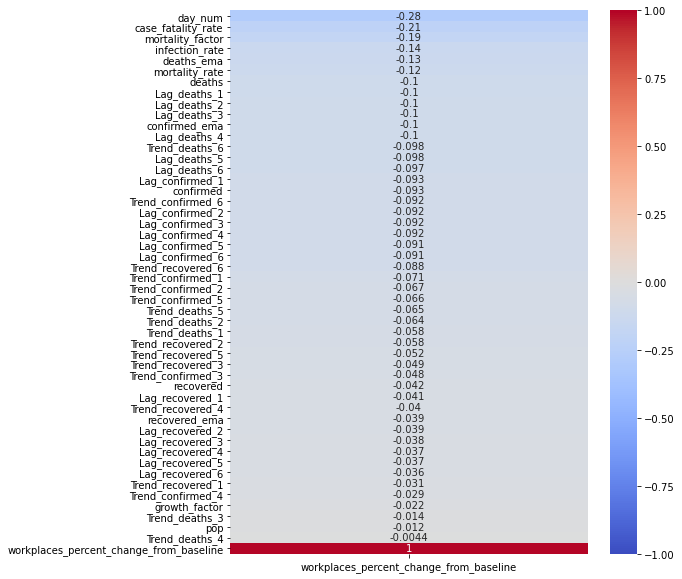

In [81]:
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id', 'covid_date',
        'retail_and_recreation_percent_change_from_baseline',	
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
    })
])

data_all_corr = corr_transform(data_all)

heatmap_numeric_w_dependent_variable(data_all_corr, 
                    'workplaces_percent_change_from_baseline')

We can observe medium negative correlations ( <= -0.2) between *workplaces_percent_change_from_baseline* and a number of COVID-19 pandemic spread features

- mortality_factor (-0.23)
- case_fatality_rate

## Correlations with residential_percent_change_from_baseline

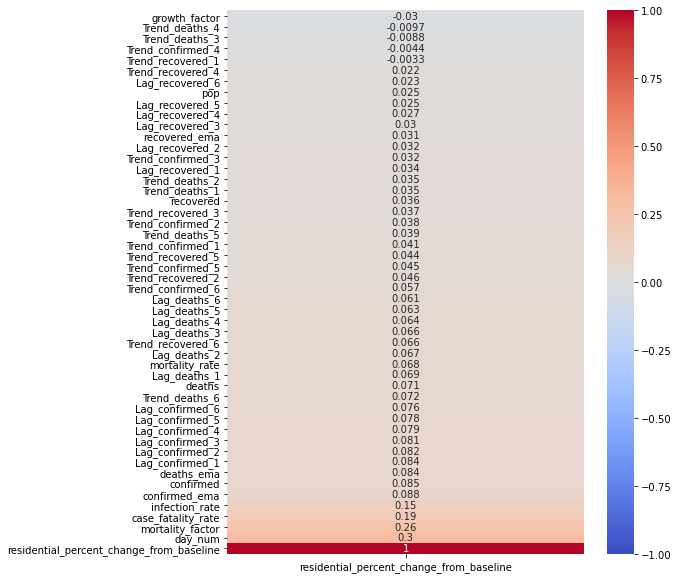

In [82]:
corr_transform = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id',	'covid_date',
        'retail_and_recreation_percent_change_from_baseline',	
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline'
    })
])

data_all_corr = corr_transform(data_all)

heatmap_numeric_w_dependent_variable(data_all_corr, 
                    'residential_percent_change_from_baseline')

We can observe medium positive correlations (> 0.2 ) between *residential_percent_change_from_baseline* and a number of COVID-19 pandemic spread features

- mortality_factor (0.29)
- case_fatality_rate

## Correlation Analysis Take-Aways

None of Google Mobility Trend features demonstrate any strong correlation with any of the COVID-19 pandemic features. It is an essential take-away it clearly shows lack of strong impact of the changes in human behaviour / population mobility trends on actual spread of and mortality from COVID-19.

There are different drivers explaining COVID-19 pandemic statistics outside the mobility trend features.

Another policy-related take-away is I cannot draw any data-driven intelligence on the statistically proven positive effect of mobility limitations (after the quarintine / lockdown containment measures launched across the globe.

# Clustering Countries by Google Mobility Trend Patterns

The purpose of the clustering experiments  is to try to find the informative clustering of countries by certain patterns in their Google Mobile Trend statistics. If a relevant clustering calculated/found, it will add an edge to 

- grouping countries with similar Google Mobility Trend behaviour
- analizing the impact of COVID-19 pandemic in each country group
- providing the ground to use Google Mobility Trend-based clustering in future ML efforts to predict the pandemic spread in a cluster-then-predict setup

In the sections below, we are going to undertake two basic experiments

- clustering in the entire (highly diminsional) space of numeric Google Mobility Trend features
- 2-dimensional clustering in ( *residential_percent_change_from_baseline* - *parks_percent_change_from_baseline* ) space, using KMeans clustering approach
- 

## Higly-dimensional Clustering Experiment

In this mini-research, we are going to use all of 6 numeric features in Google Mobility Trend dataset.

As we are going to operate in a 6-dimensional space to cluster countries by Google Mobility Trend attributes, we will use the motivation conveyed by https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6 to use DBSCAN as a clustering algorithm.

First of all, we will prepare the dataset for the clustering analysis by calculating mean values of each Google Mobile Trend by countries.

In [83]:
# dataset for clustering analysis
clustering_gmt_df = google_mobility_df.groupby('country_id').mean().reset_index()

display(clustering_gmt_df.head())

country_id  retail_and_recreation_percent_change_from_baseline  \
0         AE                                         -33.593254    
1         AF                                         -30.785714    
2         AG                                         -33.630952    
3         AO                                         -28.537037    
4         AR                                         -54.214286    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                         -14.369048   
1                                         -15.730159   
2                                         -20.619048   
3                                         -13.896827   
4                                         -21.932063   

   parks_percent_change_from_baseline  \
0                          -42.882084   
1                          -14.031746   
2                          -21.472222   
3                          -24.341270   
4                          -63.802857   

   transit_stations_percent_change_from_baseline  \
0                                     -42.313493   
1                                     -31.896825   
2                                     -45.354494   
3                                     -39.883599   
4                                     -50.755582   

   workplaces_percent_change_from_baseline  \
0                               -24.822421   
1                               -24.373016   
2                               -35.439551   
3                               -13.564817   
4                               -24.029524   

   residential_percent_change_from_baseline  
0                                 16.775322  
1                                  8.333333  
2                                 14.493421  
3                                 15.281746  
4                                 15.467619

Now we are going to compute the DBSCAN clusters. Let's import neccessary packages as well as initialize the auxiliary objects to be used down the road

In [84]:
# build the clustering model
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

drop_country_pipe = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id'
    })
])

X = drop_country_pipe(clustering_gmt_df)

X = X.fillna(0)

X = StandardScaler().fit_transform(X)

Now we are going to determine the best value for *eps* (the observation distance threashold), using the approach explained in 
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc


In [85]:
# determine the best value for eps , using the approach in 
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [86]:
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

##### The optimal value for *epsilon* will be found at the point of maximum curvature in the curve above. It looks like eps = 1.44.

We train our DBSCAN model, selecting 1.44 for eps and setting min_samples to 8.

In [87]:
# Compute DBSCAN
db = DBSCAN(eps=1.44, min_samples=8).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 4
Silhouette Coefficient: 0.320


Finally, we are going to plot the clustering results

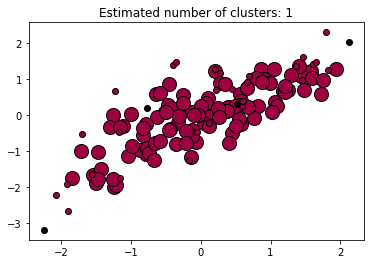

In [88]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

As we can see, as of the time of running the latest session for this notebook (Jun 13, 2020), it computed one dense cluster and a number of noise points (countries with the outstanding average mobility trend patterns).

**Note**: the result is drastically changed from Jun 12 where the best computation displayed 2 cluster plus a bunch of noise data. It can be explained by the major data update happened on Google end.

Now we are going to assign the clustering labels back to the countries to see what it looks like.

In [89]:
clustering_gmt_df['cluster'] = labels

We will see the specific charactericstics of the clusters, in terms of Google Mobility Trend averages:

In [90]:
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  retail_and_recreation_percent_change_from_baseline  \
0       -1                                         -33.249161    
1        0                                         -31.940579    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                         -17.471739   
1                                         -15.338604   

   parks_percent_change_from_baseline  \
0                          -31.470586   
1                          -12.629976   

   transit_stations_percent_change_from_baseline  \
0                                     -41.704145   
1                                     -35.300363   

   workplaces_percent_change_from_baseline  \
0                               -19.691239   
1                               -23.175433   

   residential_percent_change_from_baseline  
0                                 15.218254  
1                                 12.320652

We can interpret the computed clustes as follows

- cluster with index -1 (noisy countries without affirmative DBSCAN cluster labelling): intensively visiting parks (despite the lockdown restrictions), smaller reduction in *retail_and_recreation_percent_change_from_baseline*, smaller increase in *residential_percent_change_from_baseline*, and greater reduction in the rest of attributes vs. the core cluster
- cluster with index 0: core countries cluser

The fact of the core cluster to contain almost alll of the globe (as of Jun 13, 2020) confirms the earlier drawn intelligence as for the google mobility trends relations with the COVID-19 pandemic features. Since the core cluster contains both the countries considered to be excellent in the pandemic containment (like Germany) and ones with the poor conduct (like Brazil or India), it can be regarded to as another proof of the google mobility trends not showing strong correlation / having direct impact on the COVID-19 pandemic statistics.

We are going to review the list of the countries in the noisy bucket (cluster with the index -1):

In [91]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == -1]['country_id'].sort_values().values.tolist(), end=" ")

['GW', 'PG', 'RE', 'SG'] 

As we can see, the noise bucket contains Denmark (DK) and Sweden (SE) that have been highly criticised for the lack of strong lockdown measures in containing Covid-19 spread. Two other bucket 'members' are Guinea-Bissau (GW) and Reunion Island (RE)

## 2-dimensional clustering in ( *residential_percent_change_from_baseline* - *parks_percent_change_from_baseline* ) space

As manifested by the correlation analysis above, *residential_percent_change_from_baseline* and *parks_percent_change_from_baseline* features can draw interesting analytical insights on various mobility patterns adopted in different countries across the globe.

Reducing the clustering feature space to 2 will allow for more relevant utilization of Euclidian distance-based clustering algorithms (like KMeans clustering).

However, the weak side of such algorithms is a certain voluntarism of a researcher in specifying the number of target clusters to be calculated by the analytical software before the actual analysis started. Thus the final clustering composition is very sensitive to the decision on the number of clusters to calculate (and thus the real analytical edge of the clustering composition could be less then useful).

To mitigate such a risk, we are going to put some data-driven ground into selection of a number of clusters to calculate for our current KMeans clustering experiment, using so called *'silhouette analysis'* (as explained in https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

For n_clusters = 2 The average silhouette_score is : 0.414380082004025
For n_clusters = 3 The average silhouette_score is : 0.46273869113674776
For n_clusters = 4 The average silhouette_score is : 0.4486847319642265
For n_clusters = 5 The average silhouette_score is : 0.40316894899331823
For n_clusters = 6 The average silhouette_score is : 0.40330656069708726


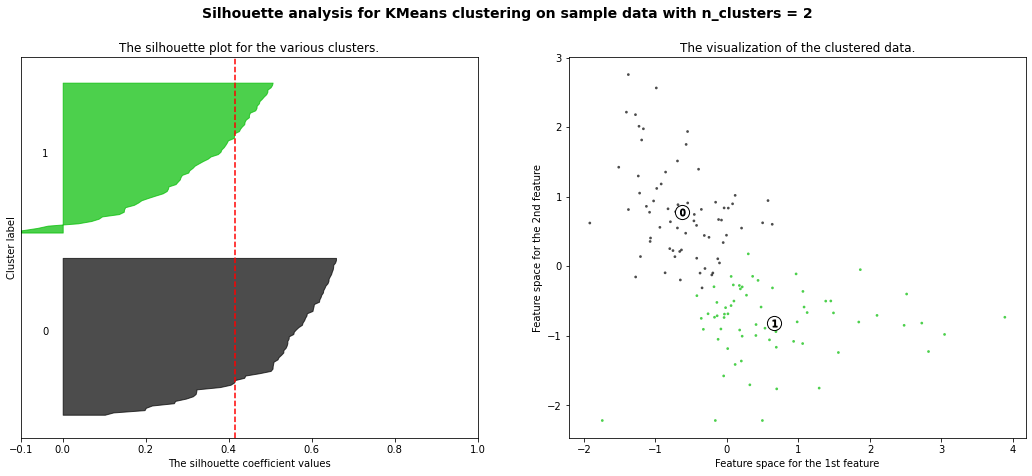

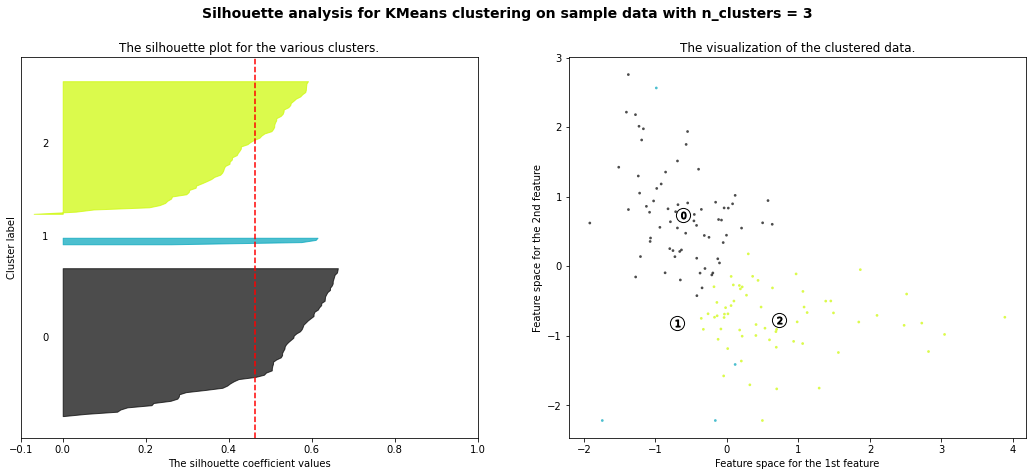

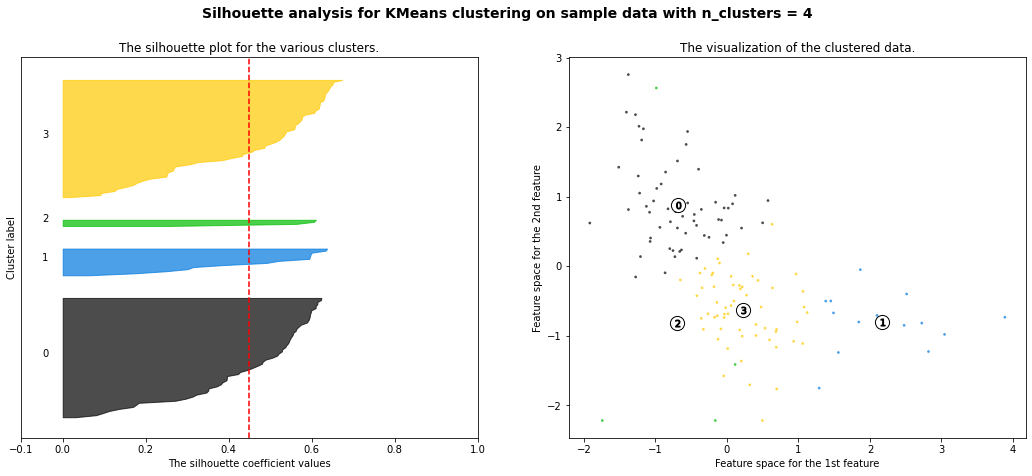

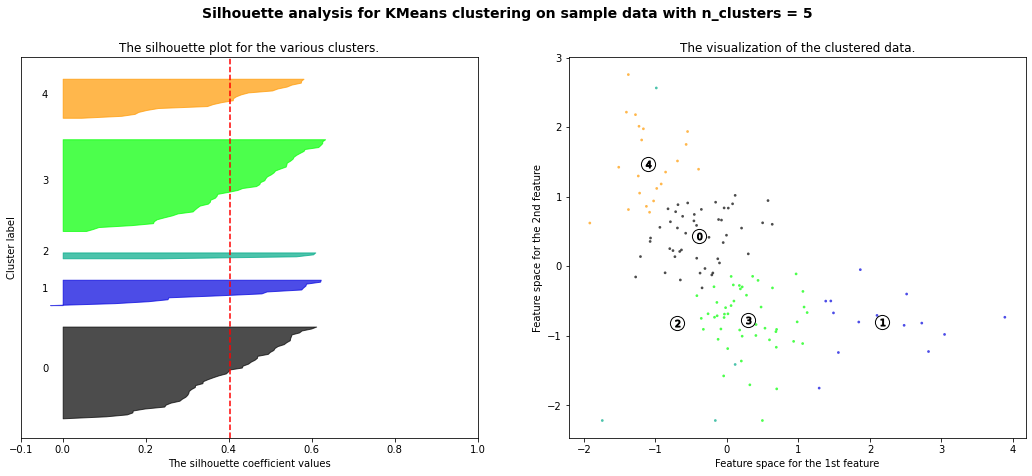

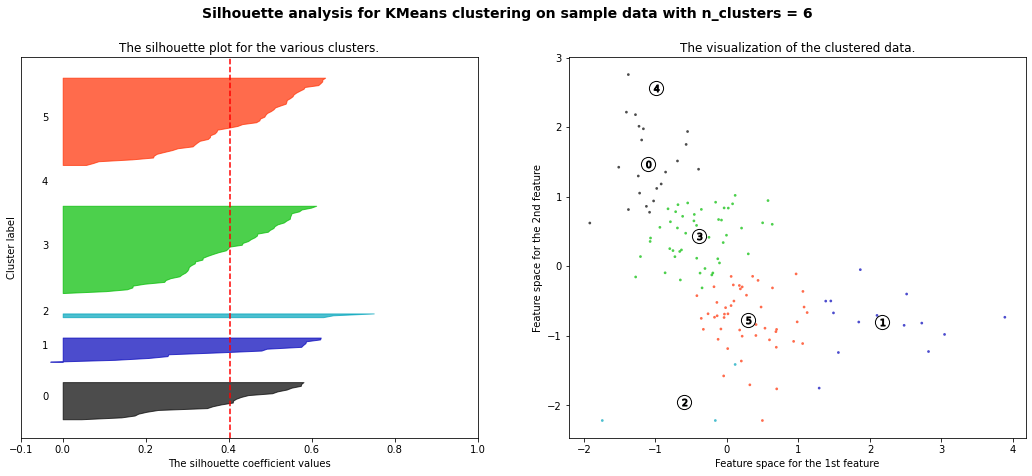

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# subset just two features in a dataframe for clustering analysis
drop_non_used_features_pipe = pdp.PdPipeline([
    pdp.ColDrop ({
        'country_id',
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline'
    })
])

dim2_clustering_df = drop_non_used_features_pipe(clustering_gmt_df)

dim2_clustering_df = dim2_clustering_df.fillna(0)

X = StandardScaler().fit_transform(dim2_clustering_df)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The silhouette plot shows that the n_clusters value of 2, 3, and 4 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. 

However, Silhouette analysis is more inclined to recommend computing 5 or 6 clusters on our dataset.

Also from the thickness of the silhouette plot the cluster size can be visualized. 

Now, we are going to apply *KMean clustering* with *5* clusters to compute on our feature space dataset.

In [93]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(n_clusters=5)

Then we learn the cluster labels

In [94]:
clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

Now we assign the clustering labels to the countries

In [95]:
# assign the clustering labels
clustering_gmt_df['cluster'] = clusters

We will see the specific charactericstics of the clusters, in terms of Google Mobility Trend averages:

In [96]:
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  retail_and_recreation_percent_change_from_baseline  \
0        0                                         -24.076949    
1        1                                         -20.237542    
2        2                                         -33.249161    
3        3                                         -36.307693    
4        4                                         -47.734641    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                          -9.111537   
1                                          -2.924327   
2                                         -17.471739   
3                                         -18.102498   
4                                         -31.530611   

   parks_percent_change_from_baseline  \
0                           -5.488824   
1                           44.369843   
2                          -31.470586   
3                          -23.301443   
4                          -42.220510   

   transit_stations_percent_change_from_baseline  \
0                                     -27.194072   
1                                     -24.602807   
2                                     -41.704145   
3                                     -39.620275   
4                                     -51.086647   

   workplaces_percent_change_from_baseline  \
0                               -16.319760   
1                               -22.553537   
2                               -19.691239   
3                               -25.551753   
4                               -33.828551   

   residential_percent_change_from_baseline  
0                                  8.054839  
1                                  7.714022  
2                                 15.218254  
3                                 14.427787  
4                                 20.122727

As we see, there is a statistically significant difference between the countries in each cluster. We can interpret the computed clustes as follows

- cluster 0: *'mobility centrists'* (the trend changes in between the outher clusters below)
- cluster 1: *'mobility workaholic liberals'* (the biggest drops in terms of *retail_and_recreation_percent_change_from_baseline*,   *parks_percent_change_from_baseline* and	*workplaces_percent_change_from_baseline*; the second biggest drop in *grocery_and_pharmacy_percent_change_from_baseline*,and *transit_stations_percent_change_from_baseline*; the biggest increase in *residential_percent_change_from_baseline*)
- cluster 2: *'countries with messy data'* (bigger drops in *retail_and_recreation_percent_change_from_baseline*, *grocery_and_pharmacy_percent_change_from_baseline*, *transit_stations_percent_change_from_baseline*, and	*workplaces_percent_change_from_baseline* vs. cluster 0; outstanding increase in *parks_percent_change_from_baseline*; messy data in *residential_percent_change_from_baseline*)
- cluster 3: *'mobility concervatives'* (moderate drop in *retail_and_recreation_percent_change_from_baseline*, *grocery_and_pharmacy_percent_change_from_baseline*, and *transit_stations_percent_change_from_baseline* - only countries in *cluster 0* display the smaller drop; smallest drop in *workplaces_percent_change_from_baseline* vs. the rest of the clusters; quite a small drop in *parks_percent_change_from_baseline*; smaller increase in *residential_percent_change_from_baseline* - only countries in *cluster 0* display the smaller increase)
- cluster 4: *'mobility parkoholic liberals'* (the lowest drops in terms of *retail_and_recreation_percent_change_from_baseline*, *grocery_and_pharmacy_percent_change_from_baseline*, *transit_stations_percent_change_from_baseline*, and	*workplaces_percent_change_from_baseline*; huge increase in *parks_percent_change_from_baseline*; moderate increase in *residential_percent_change_from_baseline*)


We are going to review the list of countries fitting into the core cluster 0 (*'mobility parkoholic liberals'*):

In [97]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 0]['country_id'].values.tolist(), end=" ")

['AF', 'AT', 'AU', 'BA', 'BF', 'BG', 'BJ', 'CH', 'CI', 'CM', 'CZ', 'EG', 'FJ', 'GE', 'GR', 'HR', 'HT', 'JP', 'KG', 'KH', 'KZ', 'LA', 'LB', 'LI', 'LV', 'LY', 'MD', 'MK', 'ML', 'MM', 'MN', 'MZ', 'NE', 'NI', 'PK', 'PL', 'RO', 'RS', 'RU', 'SI', 'TJ', 'TR', 'TW', 'TZ', 'UA', 'VN', 'YE', 'ZM'] 

Now we are going to review the list of countries fitting into the core cluster 1 (*'mobility conservatives'*):

In [98]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 1]['country_id'].values.tolist(), end=" ")

['BY', 'CA', 'DE', 'DK', 'EE', 'FI', 'HU', 'KR', 'LT', 'NL', 'NO', 'SE', 'SK', 'US'] 

Now we are going to review the list of countries fitting into the core cluster 2 (*'remote countries with messy data'*):

In [99]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 2]['country_id'].values.tolist(), end=" ")

['GW', 'PG', 'RE', 'SG'] 

Now we are going to review the list of countries fitting into the core cluster 3 (*'mobility workaholic democrates'*):

In [100]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 3]['country_id'].values.tolist(), end=" ")

['AG', 'AO', 'AW', 'BB', 'BD', 'BE', 'BH', 'BR', 'BW', 'BZ', 'CR', 'CV', 'ES', 'FR', 'GA', 'GB', 'GH', 'GT', 'HK', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IT', 'JM', 'JO', 'KE', 'LU', 'MT', 'MX', 'NA', 'NG', 'NP', 'NZ', 'OM', 'PT', 'QA', 'RW', 'SA', 'SN', 'TG', 'TH', 'TT', 'UG', 'UY', 'VE', 'ZA'] 

Now we are going to review the list of countries fitting into the core cluster 4 ('mobility centrists'):

In [101]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 4]['country_id'].values.tolist(), end=" ")

['AE', 'AR', 'BO', 'BS', 'CL', 'CO', 'DO', 'EC', 'HN', 'KW', 'LK', 'MA', 'MU', 'MY', 'PA', 'PE', 'PH', 'PR', 'PY', 'SV', 'ZW'] 

We can also tell the additional story behind the calculated clusters as follows

- Cluster 2 (*'country with messy data'*) is identic to the noise bucket calculated by DBSCAN in the previous experiment above (it contains Guinea-Bissau (GW) and Reunion Island (RE))
- Cluster 0 and 3 (*'mobility liberals'*) contain both the countries with the less stressful mobility restrictions during their lockdown periods; however, we can see both the countries considered to be more successful in the pandemic containment (like Germany or Austria) as well as less successful ones (like USA, Canada, Greece etc.)
- Cluster 1 (*'mobility conservatives'*) contains both the countries with the less stressful mobility restrictions during their lockdown periods; however, we can see both the countries considered to be more successful in the pandemic containment (like United Arabian Emirates) as well as less successful ones (like Italy etc.)
- In general, this clustering options adds more analytical edge vs. DBSCAN clustering experiment above
- The fact that both nominated-to-be-successful and nominated-to-be-less-then-successful countries (by expert epidemiologist appraisal) are mixed in the clusters supports the intelligence we draw in the correlation analysis above - it looks like Google Mobility Trend featuers cannot be good predictors / success indicators to individual countries/national states being effective in COVID-19 pandemy containment

Anyway, taking the insights from this clustering experiment can be fruitful in the future in-depth per-country investigations.

## Agglomerative clustering in 2-dimensional clustering in ( *residential_percent_change_from_baseline* - *parks_percent_change_from_baseline* ) space

As we could see, 2-dimensional clustering in ( *residential_percent_change_from_baseline* - *parks_percent_change_from_baseline* ) space could yield a good and meaningful country clustering separation.

We would like to try one more clustering approach where upfrount assumptions on the number of clustering are not required. Namely, the intetion is to implement the agglomerative clustering. Agglomerative clustering is one of the hierarchical clustering methods widely used in practical ML projects.


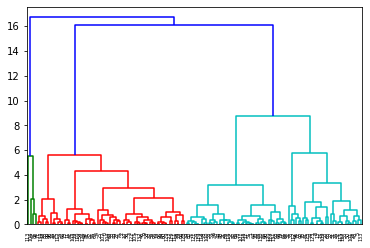

In [102]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch


dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

Looking at the dendrogram, the highest vertical distance that doesn’t intersect with any clusters is the top cyan one. Given that, the optimal number of clusters is 4.


In [103]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

display(labels)

array([2, 3, 2, 2, 2, 0, 3, 2, 0, 2, 2, 2, 3, 0, 2, 0, 2, 2, 2, 2, 0, 3,
       0, 0, 3, 2, 3, 2, 2, 2, 0, 0, 0, 2, 2, 0, 3, 2, 0, 3, 2, 2, 2, 3,
       3, 0, 2, 1, 3, 2, 0, 3, 0, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 0,
       2, 3, 3, 3, 0, 2, 0, 2, 0, 3, 2, 3, 3, 3, 3, 0, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 1, 2, 3, 0, 2, 2, 2, 2, 1, 3, 3, 0,
       2, 2, 0, 1, 3, 0, 3, 2, 3, 2, 3, 3, 2, 0, 3, 0, 2, 0, 2, 2, 3, 3,
       2, 0, 2])

Now we are going to assign the clusters back to the dataframe of countries

In [104]:
# assign the clustering labels
clustering_gmt_df['cluster'] = labels

Now we can plot the clusters calculated

In [105]:
fig = px.scatter(
    x=clustering_gmt_df['residential_percent_change_from_baseline'], 
    y=clustering_gmt_df['parks_percent_change_from_baseline'],
    color=clustering_gmt_df['cluster'],
    title='Agglomerative clusters')
fig.update_xaxes(title_text='residential_percent_change_from_baseline')
fig.update_yaxes(title_text='parks_percent_change_from_baseline')
fig.update_layout(legend_title_text='Clusters')
fig.show()

We will see the specific charactericstics of the clusters, in terms of Google Mobility Trend averages:

In [106]:
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  retail_and_recreation_percent_change_from_baseline  \
0        0                                         -22.125886    
1        1                                         -33.249161    
2        2                                         -41.777440    
3        3                                         -24.726655    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                          -3.589690   
1                                         -17.471739   
2                                         -23.562003   
3                                         -11.901127   

   parks_percent_change_from_baseline  \
0                           25.575308   
1                          -31.470586   
2                          -30.660410   
3                          -13.267226   

   transit_stations_percent_change_from_baseline  \
0                                     -24.385009   
1                                     -41.704145   
2                                     -44.505059   
3                                     -29.816921   

   workplaces_percent_change_from_baseline  \
0                               -20.418117   
1                               -19.691239   
2                               -29.860720   
3                               -15.409633   

   residential_percent_change_from_baseline  
0                                  7.502605  
1                                 15.218254  
2                                 16.792368  
3                                  9.184566

Now I am going to look at the countries in *cluster 0*:

In [107]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 0]['country_id'].values.tolist(), end=" ")

['AT', 'BA', 'BG', 'BJ', 'BY', 'CA', 'CH', 'CZ', 'DE', 'DK', 'EE', 'FI', 'GR', 'HR', 'HU', 'KR', 'LI', 'LT', 'LV', 'MN', 'NL', 'NO', 'PL', 'RU', 'SE', 'SK', 'TW', 'UA', 'US', 'ZM'] 

Now we are going to look at the countries in *cluster 1*:

In [108]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 1]['country_id'].values.tolist(), end=" ")

['GW', 'PG', 'RE', 'SG'] 

Now we are going to look at the countries in *cluster 2*:

In [109]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 2]['country_id'].values.tolist(), end=" ")

['AE', 'AG', 'AO', 'AR', 'AW', 'BB', 'BD', 'BE', 'BH', 'BO', 'BR', 'BS', 'BW', 'CL', 'CO', 'CR', 'CV', 'DO', 'EC', 'ES', 'FR', 'GA', 'GB', 'GT', 'HN', 'IE', 'IL', 'IN', 'IT', 'JM', 'JO', 'KE', 'KW', 'LK', 'LU', 'MA', 'MT', 'MU', 'MX', 'MY', 'NP', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PR', 'PT', 'PY', 'QA', 'RW', 'SA', 'SV', 'TH', 'TT', 'UG', 'UY', 'VE', 'ZA', 'ZW'] 

Now we are going to look at the countries in *cluster 3*:

In [110]:
print(clustering_gmt_df[clustering_gmt_df['cluster'] == 3]['country_id'].values.tolist(), end=" ")

['AF', 'AU', 'BF', 'BZ', 'CI', 'CM', 'EG', 'FJ', 'GE', 'GH', 'HK', 'HT', 'ID', 'IQ', 'JP', 'KG', 'KH', 'KZ', 'LA', 'LB', 'LY', 'MD', 'MK', 'ML', 'MM', 'MZ', 'NA', 'NE', 'NG', 'NI', 'PK', 'RO', 'RS', 'SI', 'SN', 'TG', 'TJ', 'TR', 'TZ', 'VN', 'YE'] 

# Future Research Directions

The reseach displayed by this notebook is by no mean complete. We are going to extend it soon.

The extension directions are envisioned as follows

1. more specific case studies for per-country mobility dynamics (with focus on European countries, Japan, Singapore, and possibly Russia)
2. additional analysis as for the correlation between the mobility trend changes and initial charts of economic slow-down caused by the quarantine/pandemic lockdown
3. providing more detailed story telling on the history of mobility trend changes over time, with some of the spikes per countries to be explained

# Data Sources

1.   JHU CoronaVirus Dataset: https://github.com/CSSEGISandData/COVID-19
2.   Google Mobility Trends dataset for COVID-19 pandemy time (since Feb 15, 2020) is maintained in Big Query Public Data project (namely, in *bigquery-public-data.covid19_google_mobility* dataset)
3.   World Bank's World Population Data as of the end of 2018 (extracted from Big Query Public Data project, *bigquery-public-data:world_bank_global_population dataset*)